# Detekcja Samochodów Przemytników - System Anomalii RTG

Ten notebook implementuje system detekcji anomalii w zdjęciach RTG samochodów przejeżdżających przez granicę.

## Pipeline:
1. **Preprocessing**: Ujednolicenie rozmiaru, korekcja orientacji, podział na kafelki
2. **Izolacja normalności**: Przygotowanie zbiorów treningowych
3. **Model**: Autoencoder do uczenia reprezentacji normalności
4. **Detekcja**: Obliczanie mapy błędu i lokalizacja anomalii
5. **Wizualizacja**: Zaznaczanie wykrytych obszarów

## 1. Importy i Konfiguracja

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from pathlib import Path
from tqdm import tqdm
import warnings
import shutil
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

# Sklearn
from sklearn.model_selection import train_test_split


#potem posortuje
from ultralytics import YOLO
import sys
import glob
import random
from pathlib import Path
import json

# Sprawdzenie GPU
device = torch.device('cuda' if torch.cuda.is_available() 
                      else torch.device('mps') if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

# Ustawienia
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Ścieżki
DATA_INITIAL_DIR = Path('./data_initial')
PROCESSED_DIR = Path('./processed')
PROCESSED_CLEAN_DIR = PROCESSED_DIR / 'czyste'
PROCESSED_ANOMALY_DIR = PROCESSED_DIR / 'brudne'

# Parametry obrazów
TARGET_WIDTH = 896
TARGET_HEIGHT = 896  # 320
BACKGROUND_COLOR = 245  # #f5f5f5

Using device: mps


## 2. Preprocessing - Pipeline data_initial/ → processed/

przycinanie


In [ ]:
import cv2
import numpy as np


def crop_white_background(image_path, threshold=240, padding=5, background_ratio=0.95, edge_scan_depth=10):
    """
    Przycina obraz w skali szarości usuwając białe tło.
    
    Args:
        image_path: Ścieżka do obrazu lub sam obraz (numpy array)
        threshold: Próg jasności - piksele jaśniejsze niż ta wartość są uważane za tło (0-255)
        padding: Dodatkowy margines wokół zawartości (w pikselach)
        background_ratio: Jaki procent pikseli w rzędzie/kolumnie musi być tłem, aby uznać ją za pustą (0-1)
        edge_scan_depth: Ile kolejnych rzędów/kolumn od krawędzi musi być tłem, aby uznać je za puste
    
    Returns:
        Przycięty obraz (numpy array)
    """
    # Wczytaj obraz jeśli podano ścieżkę
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {image_path}")
    else:
        img = image_path
    
    h, w = img.shape
    
    # Znajdź maski tła
    background_mask = img >= threshold
    
    # Sprawdź każdy rząd - ile procent to tło
    row_background_ratio = background_mask.mean(axis=1)
    
    # Sprawdź każdą kolumnę - ile procent to tło
    col_background_ratio = background_mask.mean(axis=0)
    
    # Znajdź pierwszy rząd z góry, od którego zaczyna się zawartość
    # Ignorujemy pojedyncze odstające piksele przy krawędziach
    y_min = 0
    i = 0
    while i < h - edge_scan_depth:
        # Sprawdź następne edge_scan_depth rzędów
        next_rows = row_background_ratio[i:i+edge_scan_depth]
        # Jeśli większość (co najmniej 70%) to tło, uznaj za tło
        if np.sum(next_rows >= background_ratio) >= edge_scan_depth * 0.7:
            y_min = i + edge_scan_depth
            i += edge_scan_depth
        else:
            break
    
    # Znajdź ostatni rząd od dołu
    y_max = h
    i = h - 1
    while i >= edge_scan_depth:
        start_idx = max(0, i - edge_scan_depth + 1)
        prev_rows = row_background_ratio[start_idx:i+1]
        if np.sum(prev_rows >= background_ratio) >= edge_scan_depth * 0.7:
            y_max = start_idx
            i -= edge_scan_depth
        else:
            break
    
    # Znajdź pierwszą kolumnę z lewej
    x_min = 0
    i = 0
    while i < w - edge_scan_depth:
        next_cols = col_background_ratio[i:i+edge_scan_depth]
        if np.sum(next_cols >= background_ratio) >= edge_scan_depth * 0.7:
            x_min = i + edge_scan_depth
            i += edge_scan_depth
        else:
            break
    
    # Znajdź ostatnią kolumnę z prawej
    x_max = w
    i = w - 1
    while i >= edge_scan_depth:
        start_idx = max(0, i - edge_scan_depth + 1)
        prev_cols = col_background_ratio[start_idx:i+1]
        if np.sum(prev_cols >= background_ratio) >= edge_scan_depth * 0.7:
            x_max = start_idx
            i -= edge_scan_depth
        else:
            break
    
    # Dodaj padding
    y_min = max(0, y_min - padding)
    y_max = min(h, y_max + padding)
    x_min = max(0, x_min - padding)
    x_max = min(w, x_max + padding)
    
    # Przytnij obraz
    cropped = img[y_min:y_max, x_min:x_max]
    
    return cropped


def crop_and_save(input_path, output_path, threshold=240, padding=5, background_ratio=0.95, edge_scan_depth=10):
    """
    Przycina obraz i zapisuje wynik do pliku.
    
    Args:
        input_path: Ścieżka do obrazu wejściowego
        output_path: Ścieżka zapisu przyciętego obrazu
        threshold: Próg jasności dla tła
        padding: Margines wokół zawartości
        background_ratio: Jaki procent pikseli w rzędzie/kolumnie musi być tłem
        edge_scan_depth: Głębokość skanowania od krawędzi
    """
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Nie można wczytać obrazu: {input_path}")
    
    cropped = crop_white_background(img, threshold, padding, background_ratio, edge_scan_depth)
    cv2.imwrite(output_path, cropped)
    
    return cropped


import os
from pathlib import Path


def process_directory(input_dir, output_dir, threshold=240, padding=5, background_ratio=0.95, edge_scan_depth=10):
    """
    Przetwarza wszystkie obrazy BMP w katalogu i zapisuje przycięte wersje.
    
    Args:
        input_dir: Ścieżka do katalogu wejściowego
        output_dir: Ścieżka do katalogu wyjściowego
        threshold: Próg jasności dla tła
        padding: Margines wokół zawartości
        background_ratio: Jaki procent pikseli w rzędzie/kolumnie musi być tłem
        edge_scan_depth: Głębokość skanowania od krawędzi
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    
    # Utwórz katalog wyjściowy jeśli nie istnieje
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Znajdź wszystkie pliki BMP
    bmp_files = list(input_path.glob("*.bmp"))
    
    if not bmp_files:
        print(f"Nie znaleziono plików BMP w {input_dir}")
        return
    
    print(f"Znaleziono {len(bmp_files)} plików BMP w {input_dir}")
    
    success_count = 0
    error_count = 0
    
    for i, input_file in enumerate(bmp_files, 1):
        output_file = output_path / input_file.name
        
        try:
            result = crop_and_save(
                str(input_file), 
                str(output_file), 
                threshold=threshold, 
                padding=padding, 
                background_ratio=background_ratio,
                edge_scan_depth=edge_scan_depth
            )
            
            original_shape = cv2.imread(str(input_file), cv2.IMREAD_GRAYSCALE).shape
            print(f"[{i}/{len(bmp_files)}] {input_file.name}: {original_shape} → {result.shape}")
            success_count += 1
            
        except Exception as e:
            print(f"[{i}/{len(bmp_files)}] Błąd przy {input_file.name}: {e}")
            error_count += 1
    
    print(f"\nPrzetworzono: {success_count} plików")
    if error_count > 0:
        print(f"Błędów: {error_count}")


# Przykład użycia
if __name__ == "__main__":
    # Przetwórz czyste
    print("=" * 60)
    print("Przetwarzanie data/czyste...")
    print("=" * 60)
    process_directory("data/czyste", "data_cropped/czyste")
    
    # Przetwórz brudne
    print("\n" + "=" * 60)
    print("Przetwarzanie data/brudne...")
    print("=" * 60)
    process_directory("data/brudne", "data_cropped/brudne")


PREPROCESSING: 896x896, padding #f5
Źródło: data_initial
Cel: processed

Znaleziono 138 plików
  [20/138] czyste/48001F003202511180058 czarno.bmp
  [20/138] czyste/48001F003202511180058 czarno.bmp
  [40/138] czyste/48001F003202511180071 czarno.bmp
  [40/138] czyste/48001F003202511180071 czarno.bmp
  [60/138] czyste/48001F003202511180053 czarno.bmp
  [60/138] czyste/48001F003202511180053 czarno.bmp
  [80/138] brudne/48001F003202511190108 czarno.bmp
  [80/138] brudne/48001F003202511190108 czarno.bmp
  [100/138] brudne/48001F003202511190032 czarno.bmp
  [100/138] brudne/48001F003202511190032 czarno.bmp
  [120/138] brudne/48001F003202511190110 czarno.bmp
  [120/138] brudne/48001F003202511190110 czarno.bmp

✓ Przetworzono:
  Czyste: 64
  Brudne: 74

✓ Dane gotowe w: processed/
  - processed/czyste/
  - processed/brudne/

✓ Przetworzono:
  Czyste: 64
  Brudne: 74

✓ Dane gotowe w: processed/
  - processed/czyste/
  - processed/brudne/


obracanie

In [ ]:
import cv2
import numpy as np
from pathlib import Path


def detect_car_orientation(image_path):
    """
    Wykrywa orientację samochodu na podstawie rozkładu ciemnych pikseli.
    Zakłada, że przód samochodu (koła, silnik) jest ciemniejszy niż tył.
    
    Args:
        image_path: Ścieżka do obrazu lub sam obraz (numpy array)
    
    Returns:
        'left' jeśli przód jest po lewej, 'right' jeśli po prawej
    """
    # Wczytaj obraz jeśli podano ścieżkę
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {image_path}")
    else:
        img = image_path
    
    h, w = img.shape
    
    # Podziel obraz na lewą i prawą połowę
    left_half = img[:, :w//2]
    right_half = img[:, w//2:]
    
    # Oblicz średnią jasność dla każdej połowy
    # Niższa wartość = ciemniejsze = więcej zawartości (koła, silnik)
    left_mean = left_half.mean()
    right_mean = right_half.mean()
    
    # Alternatywnie: policz ciemne piksele (< 200)
    left_dark_pixels = np.sum(left_half < 200)
    right_dark_pixels = np.sum(right_half < 200)
    
    # Przód jest tam gdzie więcej ciemnych pikseli
    if left_dark_pixels > right_dark_pixels:
        return 'left'
    else:
        return 'right'


def orient_car(image_path, target_orientation='right'):
    """
    Orientuje obraz samochodu tak, aby przód był po wskazanej stronie.
    
    Args:
        image_path: Ścieżka do obrazu lub sam obraz (numpy array)
        target_orientation: 'left' lub 'right' - gdzie ma być przód
    
    Returns:
        Obraz z odpowiednią orientacją (numpy array)
    """
    # Wczytaj obraz jeśli podano ścieżkę
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {image_path}")
    else:
        img = image_path
    
    # Wykryj aktualną orientację
    current_orientation = detect_car_orientation(img)
    
    # Jeśli trzeba, odwróć obraz
    if current_orientation != target_orientation:
        img = cv2.flip(img, 1)  # flip horizontally (1 = horizontal, 0 = vertical)
        return img, True  # True = flipped
    
    return img, False  # False = not flipped


def orient_and_save(input_path, output_path, target_orientation='right'):
    """
    Orientuje obraz i zapisuje wynik do pliku.
    
    Args:
        input_path: Ścieżka do obrazu wejściowego
        output_path: Ścieżka zapisu zorientowanego obrazu
        target_orientation: 'left' lub 'right' - gdzie ma być przód
    
    Returns:
        (oriented_image, was_flipped)
    """
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Nie można wczytać obrazu: {input_path}")
    
    oriented, flipped = orient_car(img, target_orientation)
    cv2.imwrite(output_path, oriented)
    
    return oriented, flipped


def process_directory(input_dir, output_dir, target_orientation='right'):
    """
    Przetwarza wszystkie obrazy BMP w katalogu i orientuje je.
    
    Args:
        input_dir: Ścieżka do katalogu wejściowego
        output_dir: Ścieżka do katalogu wyjściowego
        target_orientation: 'left' lub 'right' - gdzie ma być przód
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    
    # Utwórz katalog wyjściowy jeśli nie istnieje
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Znajdź wszystkie pliki BMP
    bmp_files = list(input_path.glob("*.bmp"))
    
    if not bmp_files:
        print(f"Nie znaleziono plików BMP w {input_dir}")
        return
    
    print(f"Znaleziono {len(bmp_files)} plików BMP w {input_dir}")
    
    success_count = 0
    flipped_count = 0
    error_count = 0
    
    for i, input_file in enumerate(bmp_files, 1):
        output_file = output_path / input_file.name
        
        try:
            oriented, flipped = orient_and_save(
                str(input_file), 
                str(output_file), 
                target_orientation=target_orientation
            )
            
            status = "odwrócono" if flipped else "bez zmian"
            print(f"[{i}/{len(bmp_files)}] {input_file.name}: {status}")
            success_count += 1
            if flipped:
                flipped_count += 1
            
        except Exception as e:
            print(f"[{i}/{len(bmp_files)}] Błąd przy {input_file.name}: {e}")
            error_count += 1
    
    print(f"\nPrzetworzono: {success_count} plików")
    print(f"Odwrócono: {flipped_count} plików")
    if error_count > 0:
        print(f"Błędów: {error_count}")


# Przykład użycia
if __name__ == "__main__":
    # Przetwórz przycięte obrazy - czyste
    print("=" * 60)
    print("Orientowanie data_cropped/czyste...")
    print("=" * 60)
    process_directory("data_cropped/czyste", "data_oriented/czyste", target_orientation='right')
    
    # Przetwórz przycięte obrazy - brudne
    print("\n" + "=" * 60)
    print("Orientowanie data_cropped/brudne...")
    print("=" * 60)
    process_directory("data_cropped/brudne", "data_oriented/brudne", target_orientation='right')


## 3. Przygotowanie Danych - Dataset i Split Train/Val/Test

In [222]:
class CarXRayDataset(Dataset):
    """
    PyTorch Dataset dla obrazów RTG samochodów.
    Wczytuje przetworzone obrazy z folderu 'czyste' i transformuje je do tensora.
    """
    
    def __init__(self, image_paths, transform=None):
        """
        Args:
            image_paths: Lista ścieżek do obrazów
            transform: Transformacje torchvision
        """
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Wczytaj obraz w skali szarości
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {img_path}")
        
        # Konwersja do PIL Image dla kompatybilności z torchvision
        img_pil = Image.fromarray(img)
        
        # Aplikuj transformacje
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            # Domyślna transformacja: ToTensor + normalizacja [0, 1]
            img_tensor = TF.to_tensor(img_pil)
        
        return img_tensor


# Zbierz wszystkie ścieżki do obrazów "czystych"
clean_image_paths = sorted(list(PROCESSED_CLEAN_DIR.glob('*.bmp')))

print(f"Znaleziono {len(clean_image_paths)} czystych obrazów w {PROCESSED_CLEAN_DIR}")

if len(clean_image_paths) == 0:
    raise ValueError(f"Brak obrazów w {PROCESSED_CLEAN_DIR}. Uruchom najpierw sekcję 2 (preprocessing).")

Znaleziono 64 czystych obrazów w processed/czyste


In [223]:

train_paths, temp_paths = train_test_split(
    clean_image_paths, 
    test_size=0.30, 
    random_state=SEED,
    shuffle=True
)

# Drugi split: połowa z temp idzie do val, połowa do test (po 15% każdy)
val_paths, test_paths = train_test_split(
    temp_paths, 
    test_size=0.50, 
    random_state=SEED,
    shuffle=True
)

print(f"Podział danych (czystych):")
print(f"  Train: {len(train_paths)} obrazów ({len(train_paths)/len(clean_image_paths)*100:.1f}%)")
print(f"  Val:   {len(val_paths)} obrazów ({len(val_paths)/len(clean_image_paths)*100:.1f}%)")
print(f"  Test:  {len(test_paths)} obrazów ({len(test_paths)/len(clean_image_paths)*100:.1f}%)")
print(f"  Total: {len(clean_image_paths)} obrazów")

Podział danych (czystych):
  Train: 44 obrazów (68.8%)
  Val:   10 obrazów (15.6%)
  Test:  10 obrazów (15.6%)
  Total: 64 obrazów


In [224]:
# Definicja transformacji
# Obrazy są już w docelowym rozmiarze (896x320), więc tylko normalizacja
transform = transforms.Compose([
    transforms.ToTensor(),  # Konwersja PIL Image -> Tensor [0, 1]
    # Opcjonalnie: normalizacja do [-1, 1] lub standaryzacja
    # transforms.Normalize(mean=[0.5], std=[0.5])  # -> [-1, 1]
])

# Utworzenie datasetów
train_dataset = CarXRayDataset(train_paths, transform=transform)
val_dataset = CarXRayDataset(val_paths, transform=transform)
test_dataset = CarXRayDataset(test_paths, transform=transform)

print(f"\nDatasety PyTorch:")
print(f"  Train dataset: {len(train_dataset)} obrazów")
print(f"  Val dataset:   {len(val_dataset)} obrazów")
print(f"  Test dataset:  {len(test_dataset)} obrazów")

# Test: wczytaj jeden przykład
sample_img = train_dataset[0]
print(f"\nKształt tensora: {sample_img.shape}")  # Powinno być [1, 320, 896]
print(f"Zakres wartości: [{sample_img.min():.3f}, {sample_img.max():.3f}]")
print(f"Dtype: {sample_img.dtype}")


Datasety PyTorch:
  Train dataset: 44 obrazów
  Val dataset:   10 obrazów
  Test dataset:  10 obrazów

Kształt tensora: torch.Size([1, 896, 896])
Zakres wartości: [0.075, 1.000]
Dtype: torch.float32


In [225]:
# Utworzenie DataLoaderów
BATCH_SIZE = 4  # Mały batch size dla małego datasetu

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,  # Tasowanie dla treningu
    num_workers=0,  # 0 dla macOS z MPS, można zwiększyć na CPU/CUDA
    pin_memory=True if device.type == 'cuda' else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # Bez tasowania dla walidacji
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False,  # Bez tasowania dla testu
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"DataLoadery PyTorch:")
print(f"  Train loader: {len(train_loader)} batchy po {BATCH_SIZE} obrazów")
print(f"  Val loader:   {len(val_loader)} batchy po {BATCH_SIZE} obrazów")
print(f"  Test loader:  {len(test_loader)} batchy po {BATCH_SIZE} obrazów")

# Test: pobierz jeden batch
test_batch = next(iter(train_loader))
print(f"\nKształt batcha: {test_batch.shape}")  # Powinno być [BATCH_SIZE, 1, 320, 896]
print(f"Device: {device}")
print(f"\n✓ Dane gotowe do treningu!")

DataLoadery PyTorch:
  Train loader: 11 batchy po 4 obrazów
  Val loader:   3 batchy po 4 obrazów
  Test loader:  3 batchy po 4 obrazów

Kształt batcha: torch.Size([4, 1, 896, 896])
Device: mps

✓ Dane gotowe do treningu!


## 3.5. Augmentacja Danych - Zwiększenie Datasetu

Zastosujemy sprytne augmentacje specyficzne dla obrazów RTG samochodów:
- **Additive Noise**: Symulacja szumów detektora RTG
- **Gaussian Blur**: Różne poziomy ostrości skanów
- **Brightness/Contrast**: Różne ustawienia ekspozycji
- **Horizontal Shift**: Przesunięcia poziome (auto w różnych pozycjach)
- **Slight Rotation**: Drobne rotacje (nierówne ustawienie przy skanowaniu)

In [226]:
class XRayAugmentation:
    """
    Augmentacje specyficzne dla RTG samochodów
    Zachowują realizm fizyczny skanów RTG
    """
    
    @staticmethod
    def add_noise(img, noise_factor=0.05):
        """Gaussian noise - symulacja szumów detektora"""
        noise = torch.randn_like(img) * noise_factor
        noisy = img + noise
        return torch.clamp(noisy, 0.0, 1.0)
    
    @staticmethod
    def gaussian_blur(img, kernel_size=5):
        """Rozmycie - symulacja nieostrości"""
        if kernel_size % 2 == 0:
            kernel_size += 1
        return transforms.GaussianBlur(kernel_size=kernel_size, sigma=(0.1, 2.0))(img)
    
    @staticmethod
    def adjust_brightness(img, factor=None):
        """Zmiana jasności - różne ekspozycje RTG"""
        if factor is None:
            factor = np.random.uniform(0.8, 1.2)
        return torch.clamp(img * factor, 0.0, 1.0)
    
    @staticmethod
    def adjust_contrast(img, factor=None):
        """Zmiana kontrastu - różne napięcia RTG"""
        if factor is None:
            factor = np.random.uniform(0.8, 1.2)
        mean = img.mean()
        return torch.clamp((img - mean) * factor + mean, 0.0, 1.0)
    
    @staticmethod
    def slight_rotation(img, max_angle=3, bg_value=245/255):
        """Delikatna rotacja - nierówne ustawienie przy skanowaniu"""
        angle = np.random.uniform(-max_angle, max_angle)
        
        # Konwersja tensor -> PIL -> rotate -> tensor
        img_pil = transforms.ToPILImage()(img)
        rotated = transforms.functional.rotate(
            img_pil, 
            angle, 
            fill=int(bg_value * 255)
        )
        return transforms.ToTensor()(rotated)
    
    @staticmethod
    def random_augment(img, p=0.5):
        """Losowa kombinacja augmentacji"""
        augmented = img.clone()
        
        # Noise (50% szans)
        if np.random.random() < p:
            augmented = XRayAugmentation.add_noise(augmented, noise_factor=np.random.uniform(0.01, 0.05))
        
        # Blur (30% szans)
        if np.random.random() < p * 0.6:
            augmented = XRayAugmentation.gaussian_blur(augmented, kernel_size=np.random.choice([3, 5]))
        
        # Brightness (60% szans)
        if np.random.random() < p * 1.2:
            augmented = XRayAugmentation.adjust_brightness(augmented)
        
        # Contrast (60% szans)
        if np.random.random() < p * 1.2:
            augmented = XRayAugmentation.adjust_contrast(augmented)
        
        # Rotation (30% szans)
        if np.random.random() < p * 0.6:
            augmented = XRayAugmentation.slight_rotation(augmented, max_angle=2)
        
        return augmented


def create_augmented_dataset(original_paths, augmentation_factor=3, output_dir=None):
    """
    Tworzy augmentowane obrazy z istniejących
    
    Args:
        original_paths: Lista ścieżek do oryginalnych obrazów
        augmentation_factor: Ile augmentowanych wersji na 1 obraz
        output_dir: Gdzie zapisać (opcjonalnie, None = tylko w pamięci)
    
    Returns:
        Lista wszystkich ścieżek (oryginalne + augmentowane)
    """
    transform = transforms.ToTensor()
    all_paths = list(original_paths)
    
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"Tworzenie augmentacji: {len(original_paths)} obrazów × {augmentation_factor} wersji")
    
    for img_path in tqdm(original_paths, desc="Augmentacja"):
        # Wczytaj obraz
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        img_pil = Image.fromarray(img)
        img_tensor = transform(img_pil)
        
        # Generuj augmentowane wersje
        for aug_idx in range(augmentation_factor):
            augmented = XRayAugmentation.random_augment(img_tensor, p=0.5)
            
            if output_dir:
                # Zapisz do pliku
                aug_filename = f"{img_path.stem}_aug{aug_idx}{img_path.suffix}"
                aug_path = output_dir / aug_filename
                
                # Konwersja tensor -> numpy -> zapisz
                aug_np = (augmented.squeeze().numpy() * 255).astype(np.uint8)
                cv2.imwrite(str(aug_path), aug_np)
                all_paths.append(aug_path)
    
    print(f"✓ Utworzono {len(all_paths)} obrazów (oryginalne + augmentowane)")
    return all_paths

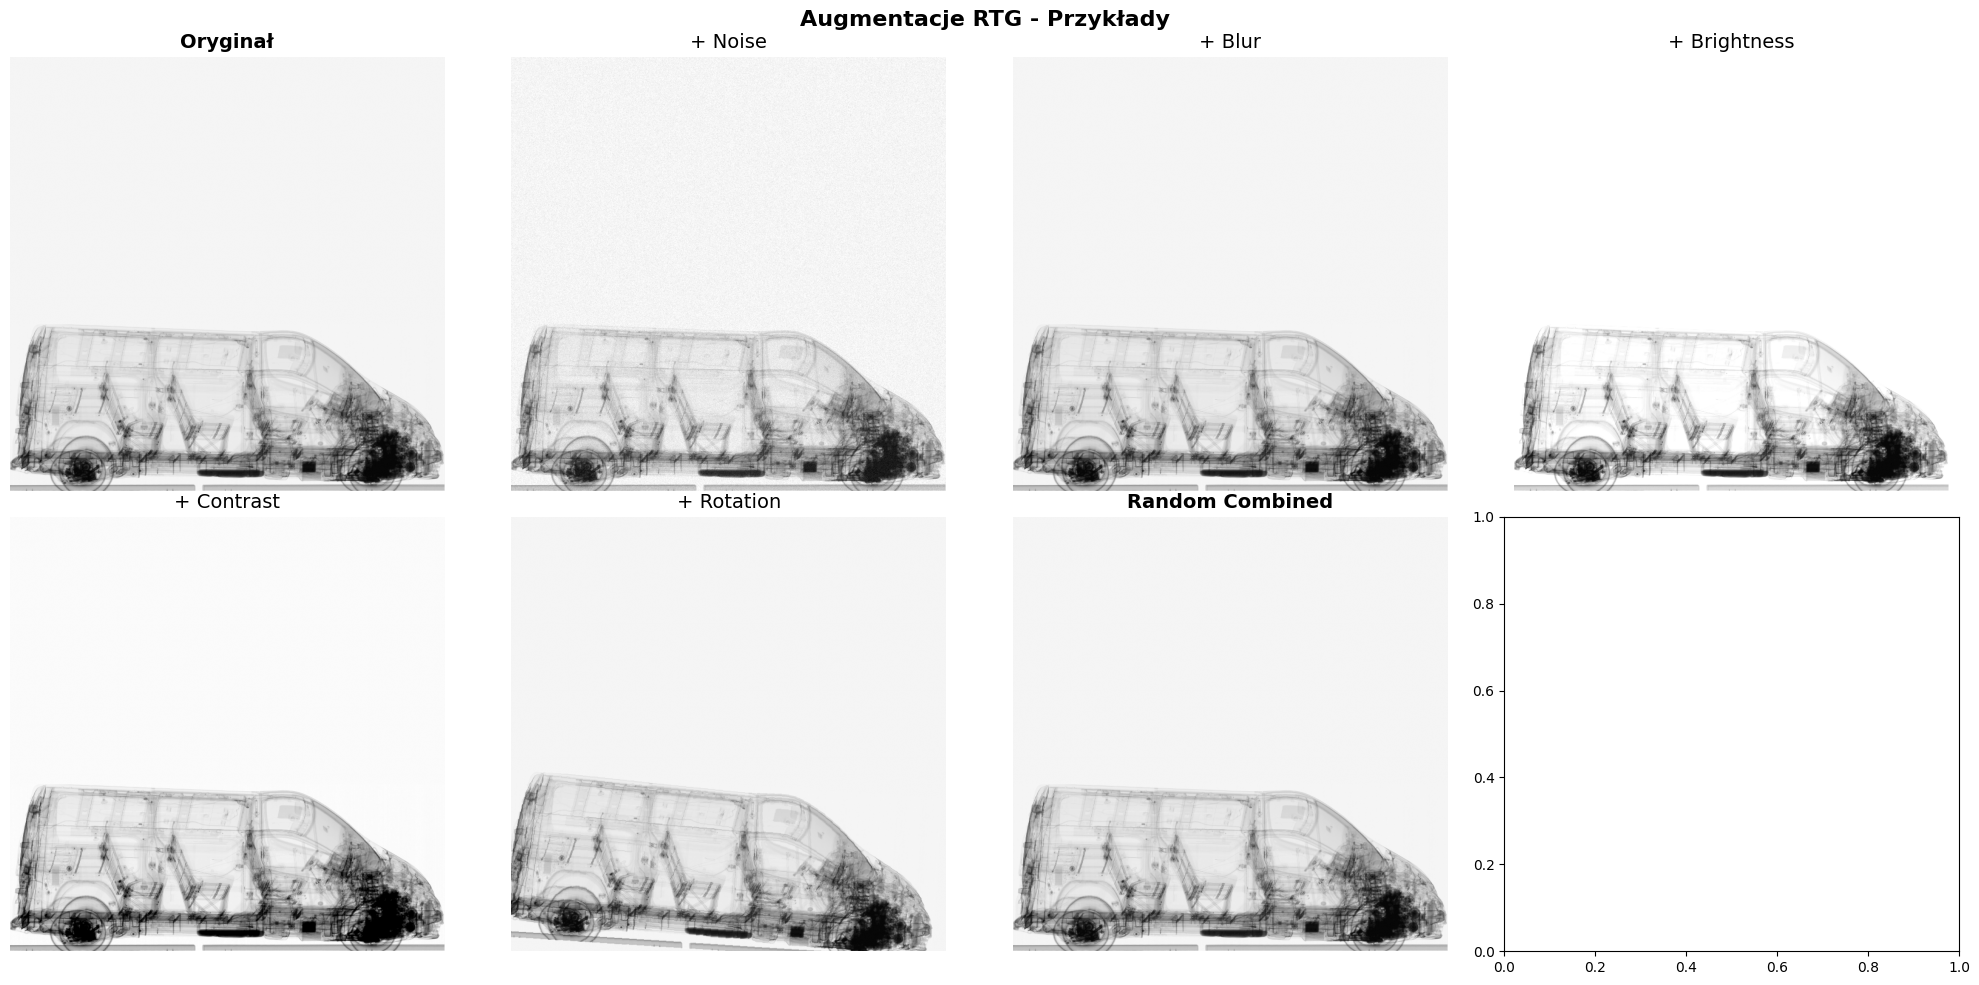

✓ Wizualizacja augmentacji gotowa!


In [227]:
# Demo augmentacji na przykładowym obrazie
if len(train_paths) > 0:
    sample_path = train_paths[0]
    img = cv2.imread(str(sample_path), cv2.IMREAD_GRAYSCALE)
    img_pil = Image.fromarray(img)
    img_tensor = transforms.ToTensor()(img_pil)
    
    # Wygeneruj różne augmentacje
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    # Oryginał
    axes[0, 0].imshow(img_tensor.squeeze(), cmap='gray')
    axes[0, 0].set_title('Oryginał', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')
    
    # Noise
    noisy = XRayAugmentation.add_noise(img_tensor, noise_factor=0.03)
    axes[0, 1].imshow(noisy.squeeze(), cmap='gray')
    axes[0, 1].set_title('+ Noise', fontsize=14)
    axes[0, 1].axis('off')
    
    # Blur
    blurred = XRayAugmentation.gaussian_blur(img_tensor, kernel_size=5)
    axes[0, 2].imshow(blurred.squeeze(), cmap='gray')
    axes[0, 2].set_title('+ Blur', fontsize=14)
    axes[0, 2].axis('off')
    
    # Brightness
    bright = XRayAugmentation.adjust_brightness(img_tensor, factor=1.1)
    axes[0, 3].imshow(bright.squeeze(), cmap='gray')
    axes[0, 3].set_title('+ Brightness', fontsize=14)
    axes[0, 3].axis('off')
    
    # Contrast
    contrast = XRayAugmentation.adjust_contrast(img_tensor, factor=1.3)
    axes[1, 0].imshow(contrast.squeeze(), cmap='gray')
    axes[1, 0].set_title('+ Contrast', fontsize=14)
    axes[1, 0].axis('off')
    
    # Rotation
    rotated = XRayAugmentation.slight_rotation(img_tensor, max_angle=15)
    axes[1, 1].imshow(rotated.squeeze(), cmap='gray')
    axes[1, 1].set_title('+ Rotation', fontsize=14)
    axes[1, 1].axis('off')
    
    # Random combined
    random_aug = XRayAugmentation.random_augment(img_tensor, p=0.8)
    axes[1, 2].imshow(random_aug.squeeze(), cmap='gray')
    axes[1, 2].set_title('Random Combined', fontsize=14, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle('Augmentacje RTG - Przykłady', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("✓ Wizualizacja augmentacji gotowa!")
else:
    print("Brak obrazów do demo")

In [228]:
# Dataset z augmentacją on-the-fly
class AugmentedCarXRayDataset(Dataset):
    """
    Dataset z augmentacją na żywo podczas treningu
    Każda epoka = różne augmentacje = większa różnorodność
    """
    
    def __init__(self, image_paths, transform=None, use_augmentation=True, aug_probability=0.5):
        """
        Args:
            image_paths: Lista ścieżek do obrazów
            transform: Bazowe transformacje (ToTensor)
            use_augmentation: Czy stosować augmentację
            aug_probability: Prawdopodobieństwo augmentacji (0-1)
        """
        self.image_paths = image_paths
        self.transform = transform
        self.use_augmentation = use_augmentation
        self.aug_probability = aug_probability
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Wczytaj obraz
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Nie można wczytać obrazu: {img_path}")
        
        img_pil = Image.fromarray(img)
        
        # Bazowa transformacja
        if self.transform:
            img_tensor = self.transform(img_pil)
        else:
            img_tensor = TF.to_tensor(img_pil)
        
        # Augmentacja (tylko dla treningu)
        if self.use_augmentation:
            img_tensor = XRayAugmentation.random_augment(img_tensor, p=self.aug_probability)
        
        return img_tensor


# Przetworzenie datasetu z augmentacją ON-THE-FLY
print("="*60)
print("TWORZENIE DATASETÓW Z AUGMENTACJĄ ON-THE-FLY")
print("="*60)

# Datasety z augmentacją
train_dataset_aug = AugmentedCarXRayDataset(
    train_paths, 
    transform=transform, 
    use_augmentation=True,  # Augmentacja dla treningu
    aug_probability=0.6     # 60% szans na augmentację
)

val_dataset_aug = AugmentedCarXRayDataset(
    val_paths, 
    transform=transform, 
    use_augmentation=False  # BEZ augmentacji dla walidacji
)

test_dataset_aug = AugmentedCarXRayDataset(
    test_paths, 
    transform=transform, 
    use_augmentation=False  # BEZ augmentacji dla testu
)

print(f"\nDatasety z augmentacją:")
print(f"  Train: {len(train_dataset_aug)} obrazów (augmentacja ON)")
print(f"  Val:   {len(val_dataset_aug)} obrazów (augmentacja OFF)")
print(f"  Test:  {len(test_dataset_aug)} obrazów (augmentacja OFF)")

# DataLoadery z augmentacją
train_loader_aug = DataLoader(
    train_dataset_aug, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

val_loader_aug = DataLoader(
    val_dataset_aug, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader_aug = DataLoader(
    test_dataset_aug, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=0,
    pin_memory=True if device.type == 'cuda' else False
)

print(f"\nDataLoadery z augmentacją:")
print(f"  Train: {len(train_loader_aug)} batchy (z augmentacją)")
print(f"  Val:   {len(val_loader_aug)} batchy (bez augmentacji)")
print(f"  Test:  {len(test_loader_aug)} batchy (bez augmentacji)")

print("\n✓ Datasety z augmentacją gotowe!")

TWORZENIE DATASETÓW Z AUGMENTACJĄ ON-THE-FLY

Datasety z augmentacją:
  Train: 44 obrazów (augmentacja ON)
  Val:   10 obrazów (augmentacja OFF)
  Test:  10 obrazów (augmentacja OFF)

DataLoadery z augmentacją:
  Train: 11 batchy (z augmentacją)
  Val:   3 batchy (bez augmentacji)
  Test:  3 batchy (bez augmentacji)

✓ Datasety z augmentacją gotowe!


## 4. Model Autoencodera

Uczenie reprezentacji normalności za pomocą Convolutional Autoencoder.

In [229]:
class ConvAutoencoder(nn.Module):
    """
    ULTRA-COMPRESSED Denoising Autoencoder dla 50 obrazów
    Input: [B, 1, 320, 896]
    Bottleneck: [B, 2, 40, 112] (8x downsampling - KOMPRESJA 32:1)
    Output: [B, 1, 320, 896]
    
    Kompresja 32:1 - model fizycznie nie może zapamiętać anomalii
    """
    
    def __init__(self, latent_channels=2, dropout_rate=0.1, noise_std=0.15, training=True):
        super(ConvAutoencoder, self).__init__()
        self.noise_std = noise_std
        self.training_mode = training
        
        # Encoder - 3 bloki (320x896 -> 40x112)
        self.encoder = nn.Sequential(
            # Blok 1: 320x896 -> 160x448
            nn.Conv2d(1, 6, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(6),
            
            # Blok 2: 160x448 -> 80x224
            nn.Conv2d(6, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            # Blok 3: 80x224 -> 40x112 (BOTTLENECK - tylko 2 kanały!)
            nn.Conv2d(8, latent_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(latent_channels),
        )
        
        self.bottleneck_dropout = nn.Dropout2d(p=dropout_rate)
        
        # Decoder
        self.decoder = nn.Sequential(
            # Blok 1: 40x112 -> 80x224
            nn.ConvTranspose2d(latent_channels, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            
            # Blok 2: 80x224 -> 160x448
            nn.ConvTranspose2d(8, 6, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(6),
            
            # Blok 3: 160x448 -> 320x896
            nn.ConvTranspose2d(6, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
    
    def add_noise(self, x):
        """Dodaje Gaussian noise do bottleneck (tylko podczas treningu)"""
        if self.training and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            return x + noise
        return x
    
    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        
        # Bottleneck z noise i dropout (tylko podczas treningu)
        if self.training:
            encoded = self.add_noise(encoded)
            encoded = self.bottleneck_dropout(encoded)
        
        # Decode
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

# Inicjalizacja modelu z ULTRA kompresją
model = ConvAutoencoder(
    latent_channels=4,
    dropout_rate=0.2,
    noise_std=0.05,
    training=True
).to(device)

total_params = sum(p.numel() for p in model.parameters())
input_size = TARGET_HEIGHT * TARGET_WIDTH
bottleneck_size = 2 * (TARGET_HEIGHT//8) * (TARGET_WIDTH//8)
compression_ratio = input_size / bottleneck_size

print(f"Parameters: {total_params:,}")
print(f"Compression: {compression_ratio:.1f}:1 ({input_size:,} -> {bottleneck_size:,})")

Parameters: 2,849
Compression: 32.0:1 (802,816 -> 25,088)


In [230]:
# Funkcja treningowa
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in dataloader:
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        loss = criterion(output, batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            loss = criterion(output, batch)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

# Setup treningu
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(), 
    lr=0.0001,
    weight_decay=1e-3
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    patience=10,
    factor=0.5
)

print("Training: LR=0.0001, L2=1e-3, patience=10")

Training: LR=0.0001, L2=1e-3, patience=10


In [231]:
# Trening modelu
NUM_EPOCHS = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []

print("Rozpoczynam trening autoencodera...")
print(f"Liczba epok: {NUM_EPOCHS}\n")

for epoch in range(NUM_EPOCHS):
    # Trening
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Walidacja
    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Zapisz najlepszy model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_autoencoder.pth')
    
    # Raportowanie
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

print("\nTrening zakończony!")
print(f"Najlepsza val loss: {best_val_loss:.6f}")

# Załaduj najlepszy model
model.load_state_dict(torch.load('best_autoencoder.pth'))
print("Załadowano najlepszy model")

Rozpoczynam trening autoencodera...
Liczba epok: 100

Epoch [5/100] - Train Loss: 0.140040, Val Loss: 0.136476
Epoch [5/100] - Train Loss: 0.140040, Val Loss: 0.136476
Epoch [10/100] - Train Loss: 0.134758, Val Loss: 0.134277
Epoch [10/100] - Train Loss: 0.134758, Val Loss: 0.134277
Epoch [15/100] - Train Loss: 0.129090, Val Loss: 0.128894
Epoch [15/100] - Train Loss: 0.129090, Val Loss: 0.128894
Epoch [20/100] - Train Loss: 0.115351, Val Loss: 0.115379
Epoch [20/100] - Train Loss: 0.115351, Val Loss: 0.115379
Epoch [25/100] - Train Loss: 0.105700, Val Loss: 0.103494
Epoch [25/100] - Train Loss: 0.105700, Val Loss: 0.103494
Epoch [30/100] - Train Loss: 0.099373, Val Loss: 0.095636
Epoch [30/100] - Train Loss: 0.099373, Val Loss: 0.095636
Epoch [35/100] - Train Loss: 0.093166, Val Loss: 0.089629
Epoch [35/100] - Train Loss: 0.093166, Val Loss: 0.089629
Epoch [40/100] - Train Loss: 0.087440, Val Loss: 0.086718
Epoch [40/100] - Train Loss: 0.087440, Val Loss: 0.086718
Epoch [45/100] - Tra

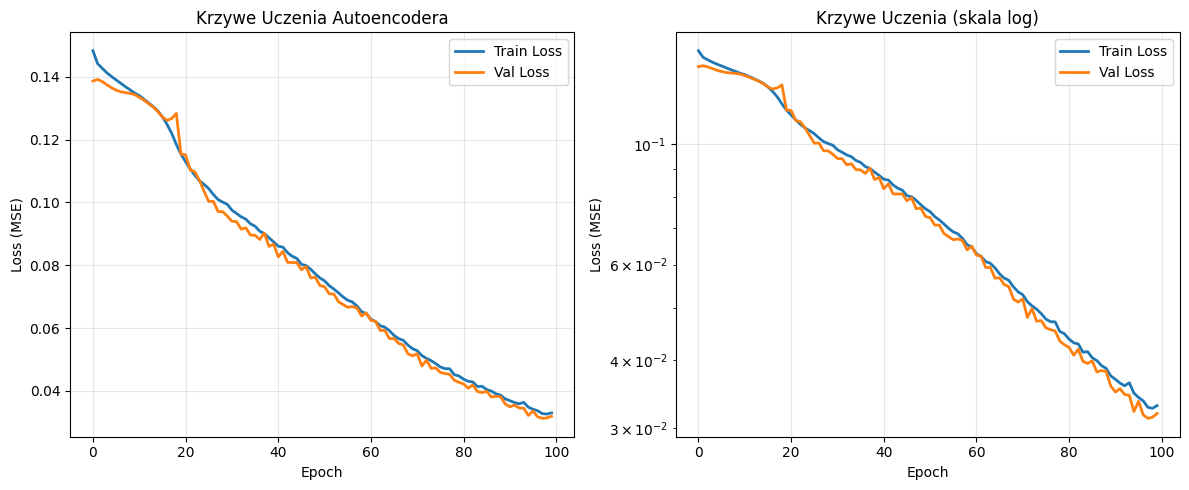

In [232]:
# Wizualizacja krzywych uczenia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Krzywe Uczenia Autoencodera')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Krzywe Uczenia (skala log)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Ustalenie Progu Anomalii (τ) - Krok 6

Obliczamy błąd rekonstrukcji na zbiorze walidacyjnym i ustalamy optymalny próg.

Błędy rekonstrukcji na zbiorze walidacyjnym:
  Średnia: 0.031298
  Std. dev: 0.000868
  95-ty percentyl: 0.032275
  99-ty percentyl: 0.032299

✓ Ustalony próg anomalii τ = 0.038759


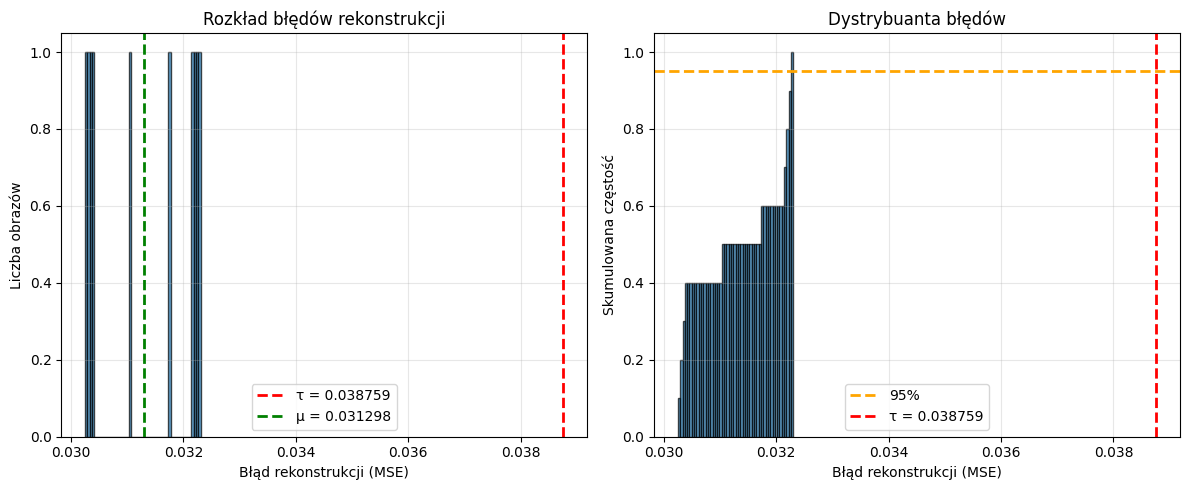

In [233]:
def compute_reconstruction_errors(model, dataloader, device):
    """Oblicza błędy rekonstrukcji dla całego datasetu"""
    model.eval()
    errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            output = model(batch)
            
            # Błąd per obraz (MSE)
            batch_errors = torch.mean((batch - output) ** 2, dim=[1, 2, 3])
            errors.extend(batch_errors.cpu().numpy())
    
    return np.array(errors)

# Oblicz błędy na zbiorze walidacyjnym
val_errors = compute_reconstruction_errors(model, val_loader, device)

# Statystyki
mean_error = np.mean(val_errors)
std_error = np.std(val_errors)
percentile_95 = np.percentile(val_errors, 95)
percentile_99 = np.percentile(val_errors, 99)

print("Błędy rekonstrukcji na zbiorze walidacyjnym:")
print(f"  Średnia: {mean_error:.6f}")
print(f"  Std. dev: {std_error:.6f}")
print(f"  95-ty percentyl: {percentile_95:.6f}")
print(f"  99-ty percentyl: {percentile_99:.6f}")

# Ustal próg τ jako 95-ty percentyl + margines
tau = percentile_99 * 1.2  # Margines bezpieczeństwa (zwiększony dla mniejszej czułości)
print(f"\n✓ Ustalony próg anomalii τ = {tau:.6f}")

# Wizualizacja rozkładu błędów
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(val_errors, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(tau, color='red', linestyle='--', linewidth=2, label=f'τ = {tau:.6f}')
plt.axvline(mean_error, color='green', linestyle='--', linewidth=2, label=f'μ = {mean_error:.6f}')
plt.xlabel('Błąd rekonstrukcji (MSE)')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład błędów rekonstrukcji')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(val_errors, bins=50, edgecolor='black', alpha=0.7, cumulative=True, density=True)
plt.axhline(0.95, color='orange', linestyle='--', linewidth=2, label='95%')
plt.axvline(tau, color='red', linestyle='--', linewidth=2, label=f'τ = {tau:.6f}')
plt.xlabel('Błąd rekonstrukcji (MSE)')
plt.ylabel('Skumulowana częstość')
plt.title('Dystrybuanta błędów')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7-11. Detekcja i Lokalizacja Anomalii

Implementacja końcowego pipeline'u:
- **Krok 7**: Obliczenie mapy błędu lokalnego
- **Krok 8**: Progowanie mapy błędu
- **Krok 9**: Grupowanie połączonych komponentów
- **Krok 10**: Bounding boxes
- **Krok 11**: Wizualizacja

In [234]:
class AnomalyDetector:
    """Detektor anomalii z lokalizacją - pure PyTorch"""
    
    def __init__(self, model, threshold, device):
        self.model = model
        self.threshold = threshold
        self.device = device
        self.model.eval()
    
    def compute_error_map(self, image_tensor):
        """
        Krok 7: Obliczenie mapy błędu lokalnego
        image_tensor: [1, H, W] torch.Tensor
        """
        with torch.no_grad():
            # Dodaj batch dim i przenieś na device
            if image_tensor.dim() == 3:
                image_tensor = image_tensor.unsqueeze(0)  # [1, 1, H, W]
            
            image_tensor = image_tensor.to(self.device)
            
            # Rekonstrukcja
            reconstruction = self.model(image_tensor)
            
            # Mapa błędu (per piksel)
            error_map = (image_tensor - reconstruction) ** 2
            error_map = error_map.squeeze(0)  # [1, H, W]
            
            reconstruction = reconstruction.squeeze(0)  # [1, H, W]
        
        return error_map, reconstruction
    
    def create_anomaly_mask(self, error_map, percentile_threshold=98):
        """
        Krok 8: Progowanie mapy błędu (maska anomalii)
        error_map: [1, H, W] torch.Tensor
        """
        # Normalizuj mapę błędu
        error_flat = error_map.flatten()
        error_min = error_flat.min()
        error_max = error_flat.max()
        error_map_normalized = (error_map - error_min) / (error_max - error_min + 1e-8)
        
        # Próg lokalny (percentyl) - wyższy = mniej regionów
        error_np = error_map_normalized.cpu().numpy().flatten()
        local_threshold = np.percentile(error_np, percentile_threshold)
        
        # Maska binarna
        anomaly_mask = (error_map_normalized.squeeze() > local_threshold).float()
        
        # Konwersja do numpy dla operacji morfologicznych
        mask_np = (anomaly_mask.cpu().numpy() * 255).astype(np.uint8)
        
        # Operacje morfologiczne - większy kernel eliminuje drobne regiony
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
        mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_CLOSE, kernel)
        mask_np = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)
        mask_np = (mask_np > 127).astype(np.uint8)
        
        return mask_np
    
    def find_bounding_boxes(self, anomaly_mask, min_area=500):
        """Krok 9-10: Grupowanie komponentów i bounding boxes"""
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            anomaly_mask, connectivity=8
        )
        
        bounding_boxes = []
        
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            
            if area >= min_area:
                x = stats[i, cv2.CC_STAT_LEFT]
                y = stats[i, cv2.CC_STAT_TOP]
                w = stats[i, cv2.CC_STAT_WIDTH]
                h = stats[i, cv2.CC_STAT_HEIGHT]
                
                bounding_boxes.append({
                    'x': x, 'y': y, 'width': w, 'height': h,
                    'area': area,
                    'centroid': centroids[i]
                })
        
        return bounding_boxes
    
    def detect_and_localize(self, image_tensor, percentile_threshold=98, min_area=500):
        """
        Pełny pipeline detekcji i lokalizacji
        image_tensor: [1, H, W] torch.Tensor
        """
        # Krok 7: Mapa błędu
        error_map, reconstruction = self.compute_error_map(image_tensor)
        
        # Krok 8: Maska anomalii
        anomaly_mask = self.create_anomaly_mask(error_map, percentile_threshold)
        
        # Kroki 9-10: Bounding boxes
        bounding_boxes = self.find_bounding_boxes(anomaly_mask, min_area)
        
        # Decyzja: czy wykryto anomalię
        global_error = error_map.mean().item()
        is_anomaly = global_error > self.threshold or len(bounding_boxes) > 0
        
        return {
            'is_anomaly': is_anomaly,
            'global_error': global_error,
            'error_map': error_map.cpu(),
            'reconstruction': reconstruction.cpu(),
            'anomaly_mask': anomaly_mask,
            'bounding_boxes': bounding_boxes
        }
    
    def visualize_detection(self, original_tensor, detection_result):
        """
        Krok 11: Wizualizacja wyniku
        original_tensor: [1, H, W] torch.Tensor
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Konwersje do numpy dla wizualizacji
        orig_np = original_tensor.squeeze().cpu().numpy()
        recon_np = detection_result['reconstruction'].squeeze().numpy()
        error_np = detection_result['error_map'].squeeze().numpy()
        
        # Oryginał
        axes[0, 0].imshow(orig_np, cmap='gray')
        axes[0, 0].set_title(f'Oryginał RTG\n{orig_np.shape[0]}×{orig_np.shape[1]}')
        axes[0, 0].axis('off')
        
        # Rekonstrukcja
        axes[0, 1].imshow(recon_np, cmap='gray')
        axes[0, 1].set_title('Rekonstrukcja')
        axes[0, 1].axis('off')
        
        # Mapa błędu
        im = axes[0, 2].imshow(error_np, cmap='hot')
        axes[0, 2].set_title('Mapa błędu lokalnego')
        axes[0, 2].axis('off')
        plt.colorbar(im, ax=axes[0, 2])
        
        # Maska anomalii
        axes[1, 0].imshow(detection_result['anomaly_mask'], cmap='gray')
        axes[1, 0].set_title('Maska anomalii')
        axes[1, 0].axis('off')
        
        # Oryginał z zaznaczonymi anomaliami (overlay)
        overlay = np.stack([orig_np, orig_np, orig_np], axis=-1)
        mask_overlay = detection_result['anomaly_mask'] > 0
        overlay[mask_overlay, 0] = 1.0  # Czerwony kanał
        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title('Nałożona maska')
        axes[1, 1].axis('off')
        
        # Bounding boxes
        img_with_boxes = np.stack([orig_np, orig_np, orig_np], axis=-1)
        img_with_boxes = (img_with_boxes * 255).astype(np.uint8)
        
        for bbox in detection_result['bounding_boxes']:
            cv2.rectangle(
                img_with_boxes,
                (bbox['x'], bbox['y']),
                (bbox['x'] + bbox['width'], bbox['y'] + bbox['height']),
                (0, 255, 0), 3
            )
            
            label = f"A:{bbox['area']}"
            cv2.putText(
                img_with_boxes, label,
                (bbox['x'], bbox['y'] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2
            )
        
        axes[1, 2].imshow(img_with_boxes)
        title = f"Regiony: {len(detection_result['bounding_boxes'])}\n"
        title += f"Błąd: {detection_result['global_error']:.6f}"
        axes[1, 2].set_title(title)
        axes[1, 2].axis('off')
        
        # Status
        status = "⚠️ ANOMALIA!" if detection_result['is_anomaly'] else "✓ NORMALNY"
        color = 'red' if detection_result['is_anomaly'] else 'green'
        fig.suptitle(status, fontsize=18, fontweight='bold', color=color)
        
        plt.tight_layout()
        plt.show()

# Inicjalizacja detektora (po treningu)
print("✓ Klasa AnomalyDetector gotowa (pure PyTorch)!")
print("  Inicjalizacja po zakończeniu treningu...")

✓ Klasa AnomalyDetector gotowa (pure PyTorch)!
  Inicjalizacja po zakończeniu treningu...


In [235]:
# Inicjalizacja detektora z wytrenowanym modelem
detector = AnomalyDetector(model, tau, device)

print("✓ AnomalyDetector zainicjalizowany!")
print(f"  Model: ConvAutoencoder")
print(f"  Próg anomalii (τ): {tau:.6f}")
print(f"  Urządzenie: {device}")
print("\nGotowy do detekcji anomalii!")

✓ AnomalyDetector zainicjalizowany!
  Model: ConvAutoencoder
  Próg anomalii (τ): 0.038759
  Urządzenie: mps

Gotowy do detekcji anomalii!


## Test Detekcji na Przykładowych Obrazach


Test obrazu 1/3
Status: ANOMALIA
Błąd globalny: 0.030377 (próg: 0.038759)
Liczba wykrytych regionów: 7

Wykryte regiony:
  Region 1: x=479, y=708, width=318, height=177, area=14686
  Region 2: x=554, y=750, width=29, height=42, area=774
  Region 3: x=253, y=813, width=128, height=64, area=3395
  Region 4: x=433, y=818, width=39, height=28, area=714
  Region 5: x=836, y=819, width=29, height=31, area=650
  Region 6: x=199, y=820, width=52, height=71, area=1560
  Region 7: x=137, y=823, width=53, height=25, area=842
Status: ANOMALIA
Błąd globalny: 0.030377 (próg: 0.038759)
Liczba wykrytych regionów: 7

Wykryte regiony:
  Region 1: x=479, y=708, width=318, height=177, area=14686
  Region 2: x=554, y=750, width=29, height=42, area=774
  Region 3: x=253, y=813, width=128, height=64, area=3395
  Region 4: x=433, y=818, width=39, height=28, area=714
  Region 5: x=836, y=819, width=29, height=31, area=650
  Region 6: x=199, y=820, width=52, height=71, area=1560
  Region 7: x=137, y=823, width

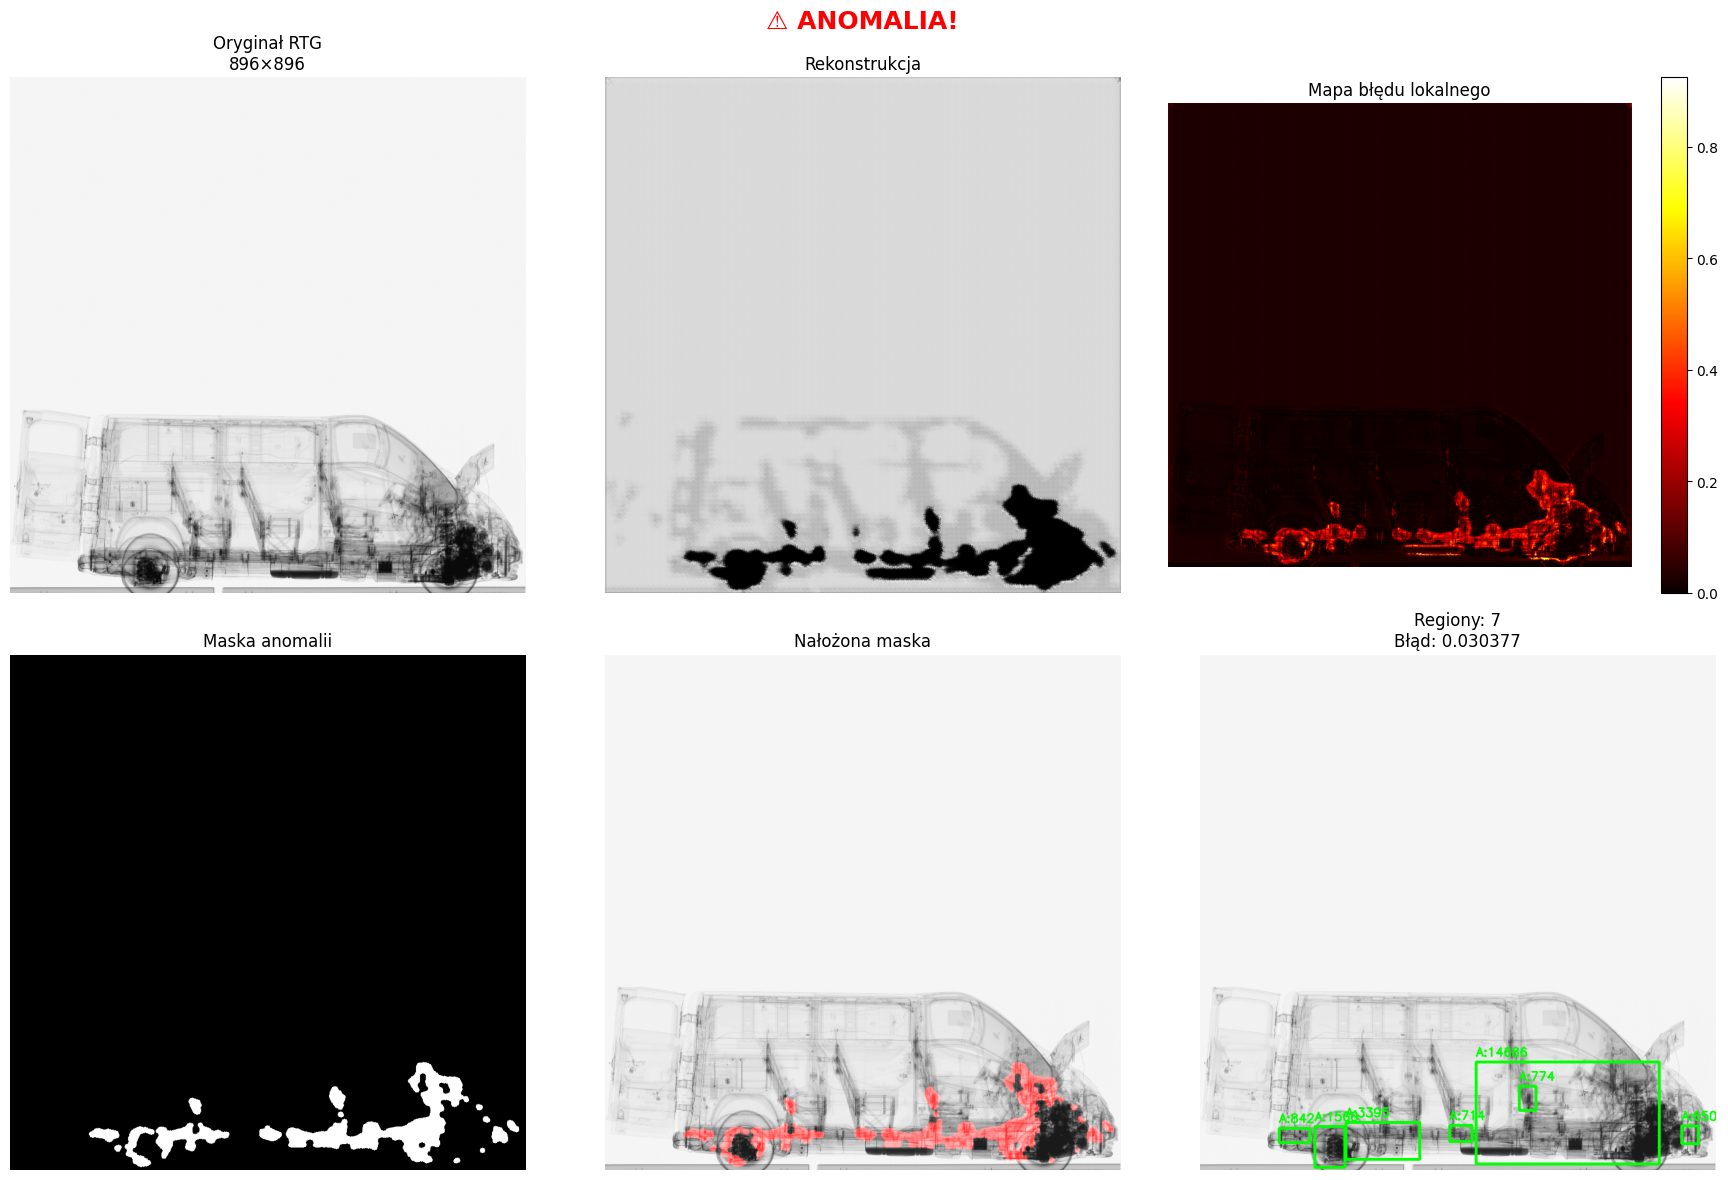


Test obrazu 2/3
Status: ANOMALIA
Błąd globalny: 0.031500 (próg: 0.038759)
Liczba wykrytych regionów: 5

Wykryte regiony:
  Region 1: x=616, y=725, width=136, height=88, area=4729
  Region 2: x=200, y=751, width=178, height=131, area=6029
  Region 3: x=796, y=758, width=59, height=87, area=1908
  Region 4: x=430, y=774, width=292, height=107, area=9742
  Region 5: x=133, y=822, width=41, height=37, area=929


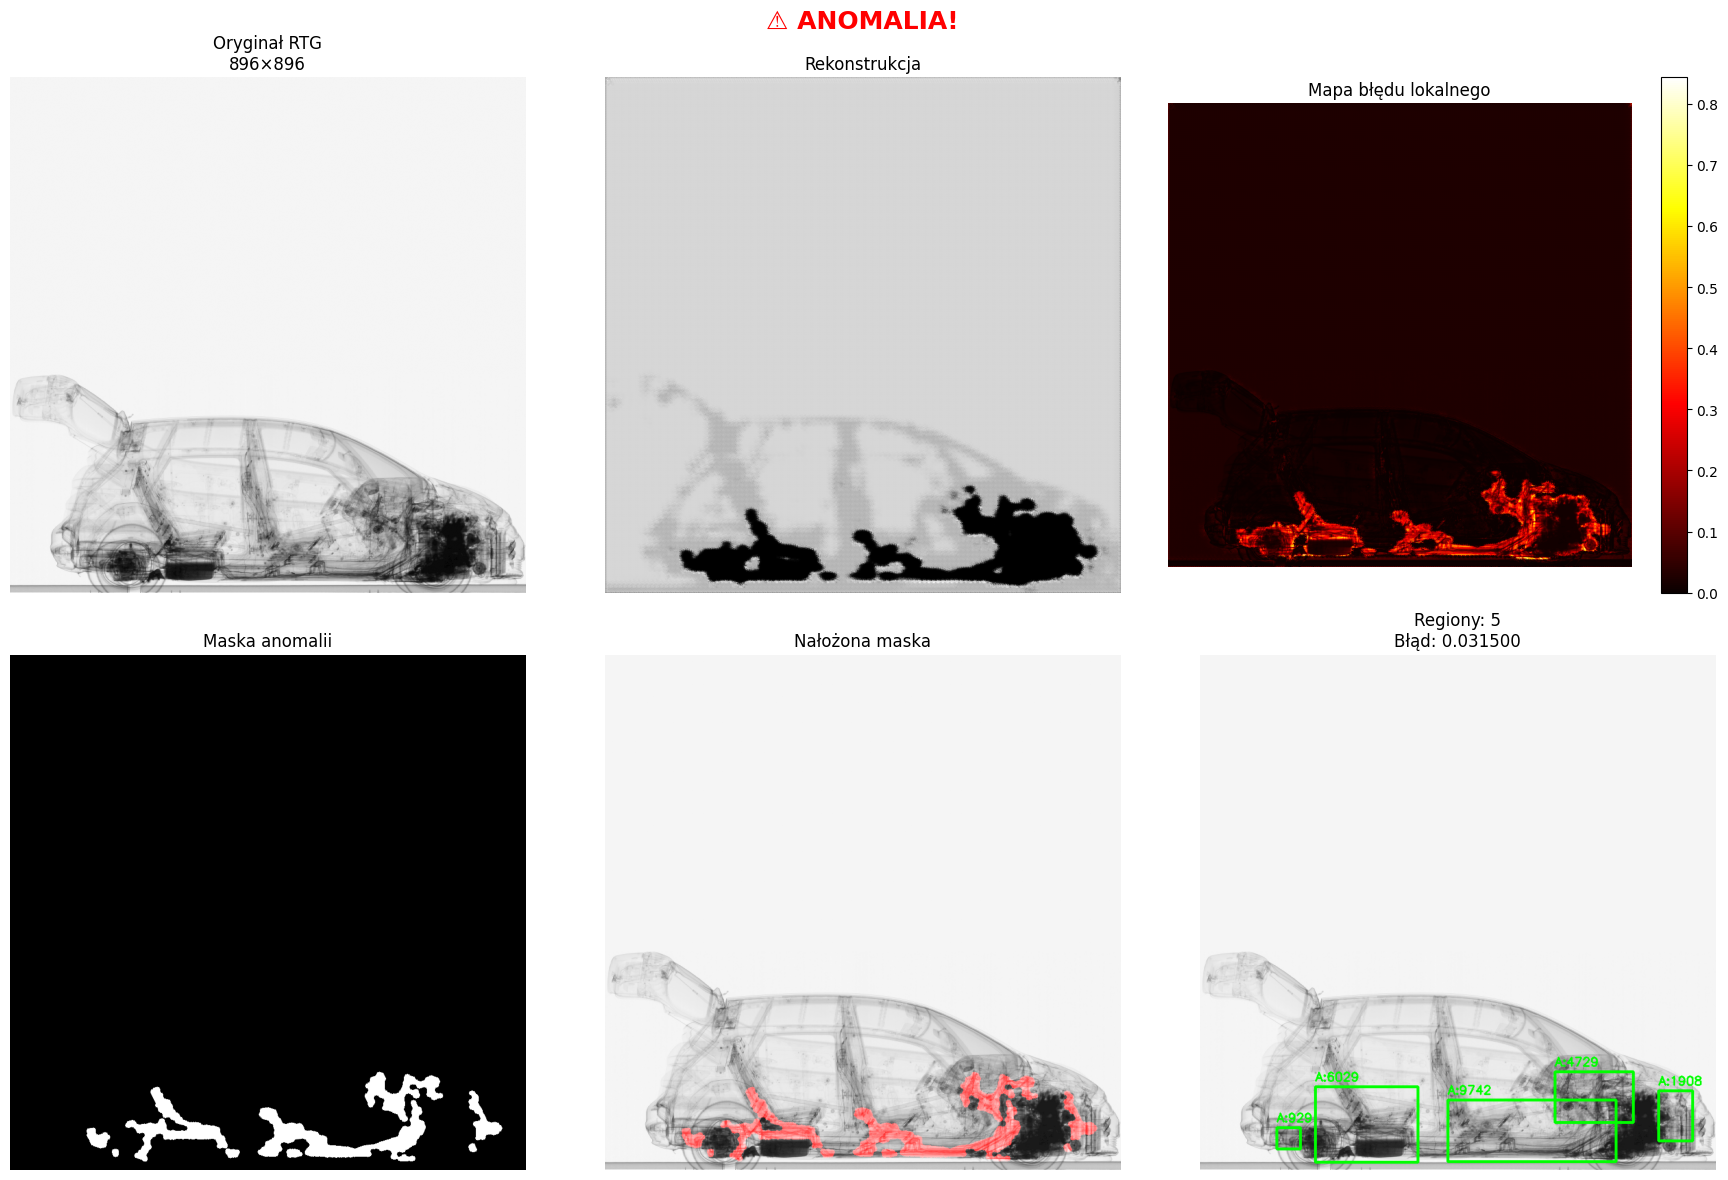


Test obrazu 3/3
Status: ANOMALIA
Błąd globalny: 0.032777 (próg: 0.038759)
Liczba wykrytych regionów: 10

Wykryte regiony:
  Region 1: x=560, y=681, width=81, height=72, area=1989
  Region 2: x=658, y=701, width=67, height=54, area=1897
  Region 3: x=186, y=731, width=33, height=29, area=646
  Region 4: x=624, y=738, width=75, height=135, area=4155
  Region 5: x=772, y=739, width=32, height=37, area=694
  Region 6: x=391, y=758, width=140, height=115, area=5819
  Region 7: x=197, y=760, width=148, height=104, area=3633
  Region 8: x=159, y=794, width=62, height=79, area=2198
  Region 9: x=794, y=794, width=30, height=34, area=539
  Region 10: x=71, y=812, width=39, height=36, area=802


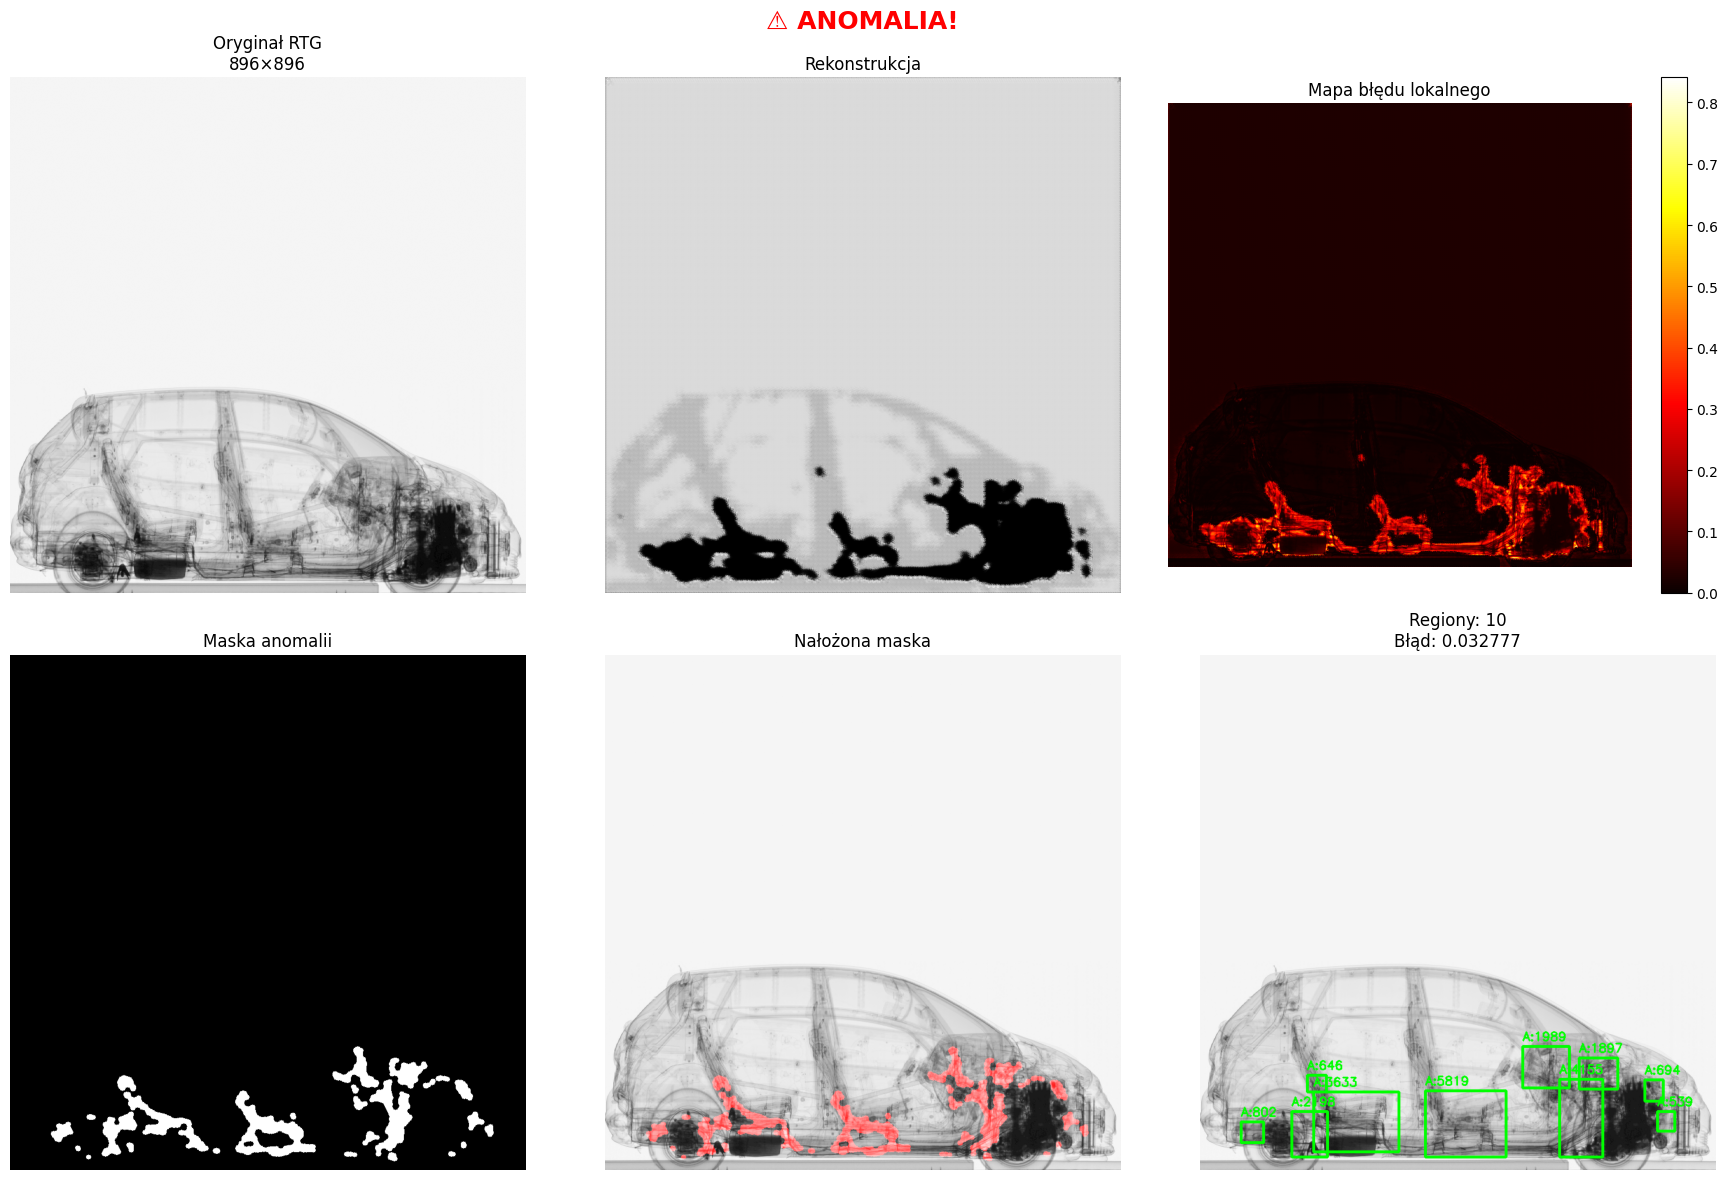

In [236]:
# Test na kilku przykładowych obrazach testowych
num_samples = 3

for i, batch_tensor in enumerate(test_loader):
    if i >= num_samples:
        break
    
    # DataLoader zwraca batch [BATCH_SIZE, 1, H, W]
    # Pobierz pierwszy obraz z batcha [1, H, W]
    image_tensor = batch_tensor[0]
    
    print(f"\n{'='*60}")
    print(f"Test obrazu {i+1}/{num_samples}")
    print(f"{'='*60}")
    
    # Detekcja - przekaż tensor [1, H, W]
    result = detector.detect_and_localize(image_tensor, percentile_threshold=98, min_area=500)
    
    print(f"Status: {'ANOMALIA' if result['is_anomaly'] else 'NORMALNY'}")
    print(f"Błąd globalny: {result['global_error']:.6f} (próg: {tau:.6f})")
    print(f"Liczba wykrytych regionów: {len(result['bounding_boxes'])}")
    
    if len(result['bounding_boxes']) > 0:
        print("\nWykryte regiony:")
        for j, bbox in enumerate(result['bounding_boxes'], 1):
            print(f"  Region {j}: x={bbox['x']}, y={bbox['y']}, "
                  f"width={bbox['width']}, height={bbox['height']}, area={bbox['area']}")
    
    # Wizualizacja
    detector.visualize_detection(image_tensor, result)

## Ewaluacja na Całym Zbiorze Testowym

Uruchamiam ewaluację na zbiorze testowym...



Przetwarzanie: 100%|██████████| 3/3 [00:00<00:00, 51.44it/s]


WYNIKI EWALUACJI
Całkowita liczba obrazów testowych: 3
Wykryte anomalie: 3 (100.0%)
Całkowita liczba wykrytych regionów: 22
Średnia liczba regionów na obraz: 7.33

Błąd globalny:
  Minimum: 0.030377
  Maksimum: 0.032777
  Średnia: 0.031551
  Mediana: 0.031500


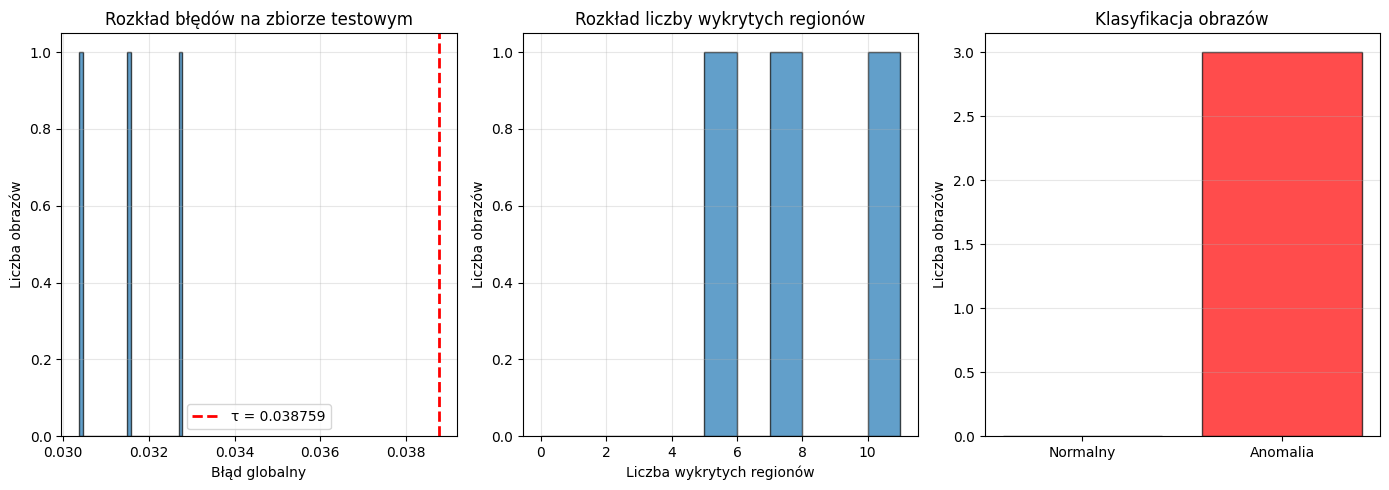

In [237]:
# Ewaluacja na całym zbiorze testowym
print("Uruchamiam ewaluację na zbiorze testowym...\n")

test_results = []
detected_anomalies = 0
total_bboxes = 0

for i, batch_tensor in enumerate(tqdm(test_loader, desc="Przetwarzanie")):
    # DataLoader zwraca batch [BATCH_SIZE, 1, H, W]
    # Pobierz pierwszy obraz z batcha [1, H, W]
    image_tensor = batch_tensor[0]
    
    result = detector.detect_and_localize(image_tensor, percentile_threshold=98, min_area=500)
    
    test_results.append({
        'image_idx': i,
        'is_anomaly': result['is_anomaly'],
        'global_error': result['global_error'],
        'num_regions': len(result['bounding_boxes'])
    })
    
    if result['is_anomaly']:
        detected_anomalies += 1
    
    total_bboxes += len(result['bounding_boxes'])

# Statystyki
print(f"\n{'='*60}")
print("WYNIKI EWALUACJI")
print(f"{'='*60}")
print(f"Całkowita liczba obrazów testowych: {len(test_results)}")
print(f"Wykryte anomalie: {detected_anomalies} ({detected_anomalies/len(test_results)*100:.1f}%)")
print(f"Całkowita liczba wykrytych regionów: {total_bboxes}")
print(f"Średnia liczba regionów na obraz: {total_bboxes/len(test_results):.2f}")

# Rozkład błędów
errors = [r['global_error'] for r in test_results]
print(f"\nBłąd globalny:")
print(f"  Minimum: {np.min(errors):.6f}")
print(f"  Maksimum: {np.max(errors):.6f}")
print(f"  Średnia: {np.mean(errors):.6f}")
print(f"  Mediana: {np.median(errors):.6f}")

# Wizualizacja rozkładu
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(errors, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(tau, color='red', linestyle='--', linewidth=2, label=f'τ = {tau:.6f}')
plt.xlabel('Błąd globalny')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład błędów na zbiorze testowym')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
num_regions = [r['num_regions'] for r in test_results]
plt.hist(num_regions, bins=range(max(num_regions)+2), edgecolor='black', alpha=0.7)
plt.xlabel('Liczba wykrytych regionów')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład liczby wykrytych regionów')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
anomaly_status = [r['is_anomaly'] for r in test_results]
labels = ['Normalny', 'Anomalia']
counts = [anomaly_status.count(False), anomaly_status.count(True)]
colors = ['green', 'red']
plt.bar(labels, counts, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Liczba obrazów')
plt.title('Klasyfikacja obrazów')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Funkcja do Przetwarzania Nowych Obrazów

Gotowe API do użycia na hackatonie.

In [238]:
def process_xray_image(image_path, detector, visualize=True):
    """
    Przetwarzanie pojedynczego obrazu RTG z processed/
    
    Parameters:
    -----------
    image_path : str lub Path
        Ścieżka do przetworzonego obrazu RTG z processed/ (.bmp)
    detector : AnomalyDetector
        Wytrenowany detektor anomalii
    visualize : bool
        Czy pokazać wizualizację
    
    Returns:
    --------
    dict : Wyniki detekcji
    """
    # Wczytaj znormalizowany obraz
    img = Image.open(image_path).convert('L')
    
    # Konwertuj do tensora [1, H, W]
    to_tensor = transforms.ToTensor()
    img_tensor = to_tensor(img)
    
    # Detekcja
    result = detector.detect_and_localize(
        img_tensor, 
        percentile_threshold=98, 
        min_area=500
    )
    
    # Przygotowanie wyniku
    output = {
        'is_smuggler': result['is_anomaly'],
        'confidence': result['global_error'],
        'num_suspicious_regions': len(result['bounding_boxes']),
        'bounding_boxes': result['bounding_boxes'],
        'recommendation': ''
    }
    
    # Rekomendacja
    if output['is_smuggler']:
        if output['num_suspicious_regions'] >= 3:
            output['recommendation'] = "🚨 ALARM - Wiele podejrzanych obszarów! Kontrola wymagana."
        elif output['num_suspicious_regions'] >= 1:
            output['recommendation'] = "⚠️ OSTRZEŻENIE - Podejrzane obszary. Zalecana kontrola."
        else:
            output['recommendation'] = "⚠️ UWAGA - Wysoki błąd rekonstrukcji. Weryfikacja."
    else:
        output['recommendation'] = "✓ OK - Brak anomalii. Samochód może przejechać."
    
    # Wizualizacja
    if visualize:
        detector.visualize_detection(img_tensor, result)
        print(f"\n{output['recommendation']}")
        print(f"Pewność (błąd): {output['confidence']:.6f}")
        print(f"Wykryte regiony: {output['num_suspicious_regions']}")
    
    return output

print("✓ Funkcja process_xray_image gotowa!")
print("\nPrzykład:")
print("result = process_xray_image('processed/czyste/48001F003202511180021 czarno.bmp', detector)")
print("lub")
print("result = process_xray_image('processed/brudne/48001F003202511180021 czarno.bmp', detector)")

✓ Funkcja process_xray_image gotowa!

Przykład:
result = process_xray_image('processed/czyste/48001F003202511180021 czarno.bmp', detector)
lub
result = process_xray_image('processed/brudne/48001F003202511180021 czarno.bmp', detector)


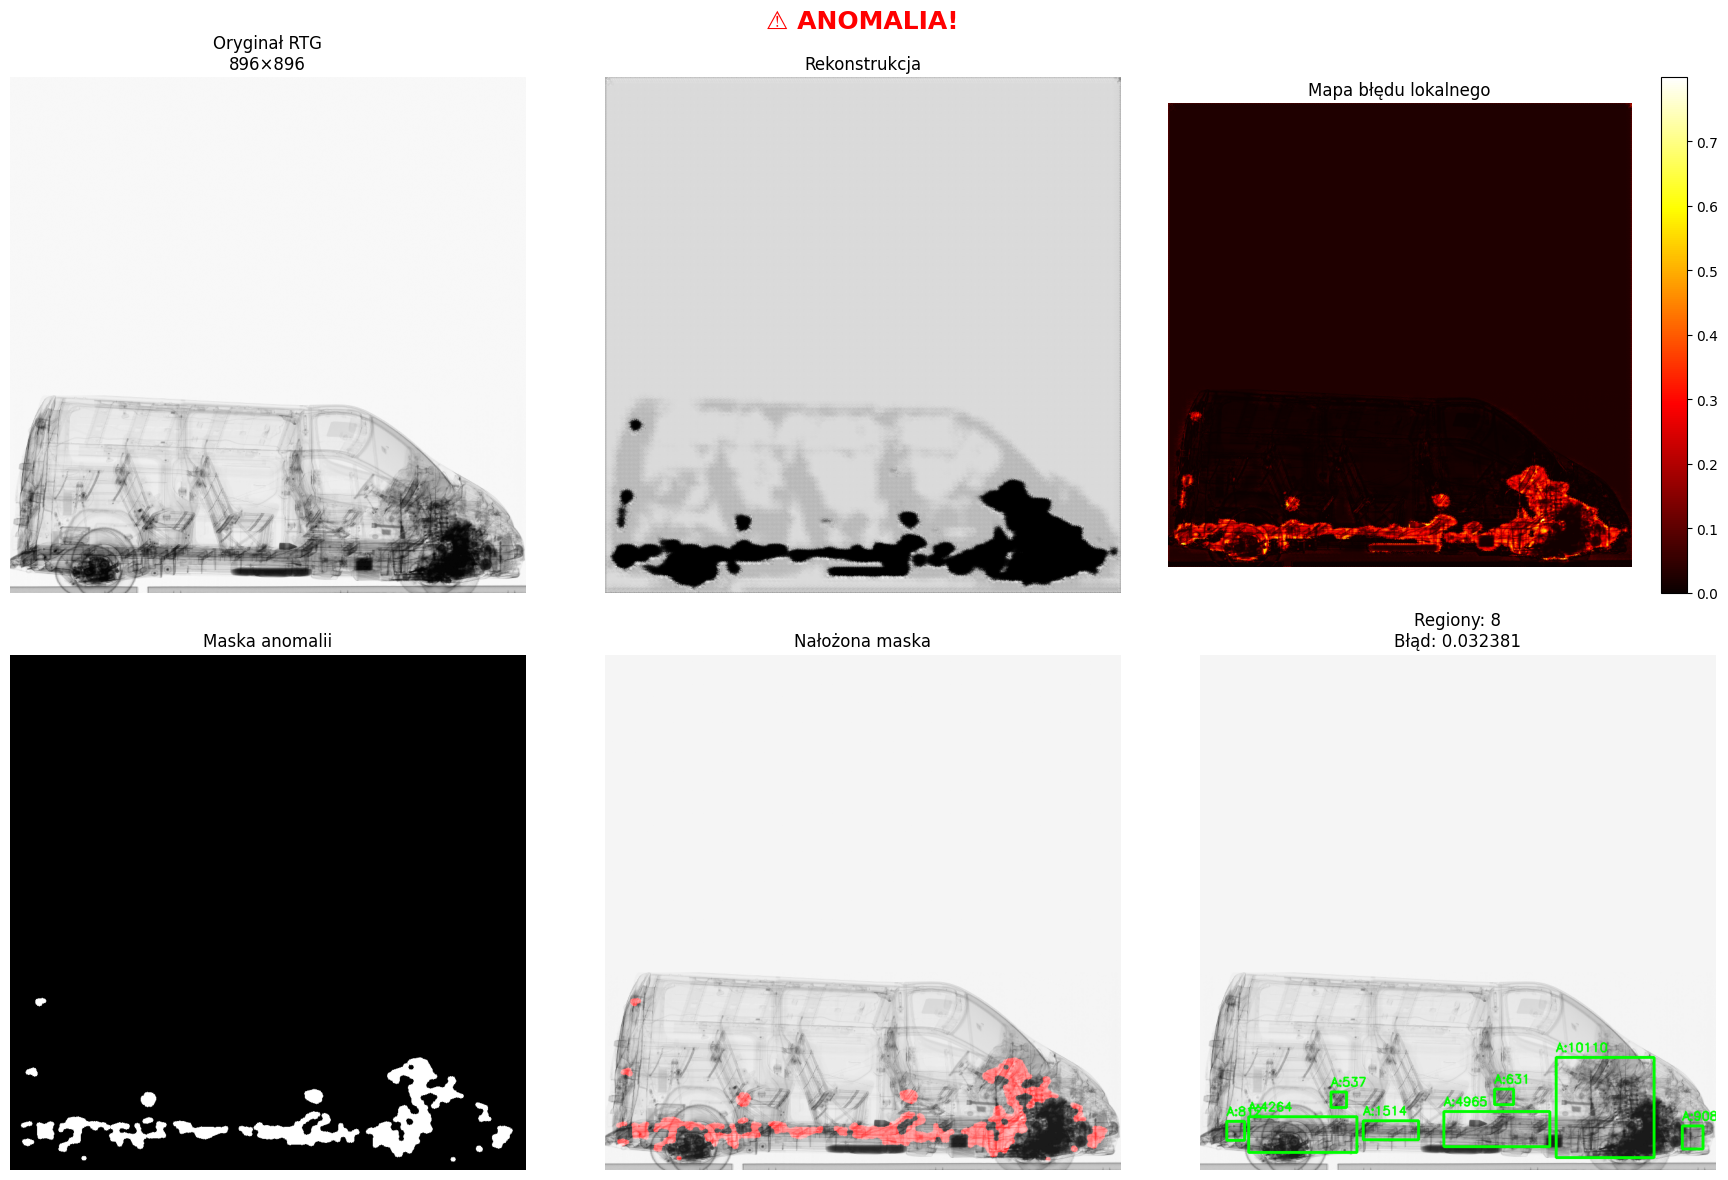


🚨 ALARM - Wiele podejrzanych obszarów! Kontrola wymagana.
Pewność (błąd): 0.032381
Wykryte regiony: 8


In [239]:
# Demo - użyj prawdziwej nazwy pliku z katalogu
result = process_xray_image('processed/brudne/48001F003202511190093 czarno.bmp', detector)

## Zapisanie Modelu i Parametrów

Zapisz model i konfigurację do późniejszego użycia.

In [ ]:

# Zapisz model
torch.save({
    'model_state_dict': model.state_dict(),
    'threshold': tau,
    'model_config': {
        'latent_dim': 128,
        'target_size': (256, 256)
    },
    'training_stats': {
        'best_val_loss': best_val_loss,
        'final_train_loss': train_losses[-1] if train_losses else None,
        'num_epochs': NUM_EPOCHS
    }
}, 'smuggler_detector_model.pth')

# Zapisz konfigurację
config = {
    'threshold': float(tau),
    'target_size': [256, 256],
    'latent_dim': 128,
    'percentile_threshold': 95,
    'min_area': 50,
    'preprocessing': {
        'threshold': 250,
        'padding': 5
    }
}

with open('smuggler_detector_config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("✓ Model zapisany: smuggler_detector_model.pth")
print("✓ Konfiguracja zapisana: smuggler_detector_config.json")
print("\nDo załadowania modelu użyj:")
print("""
model = ConvAutoencoder(latent_dim=128)
checkpoint = torch.load('smuggler_detector_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
tau = checkpoint['threshold']
detector = AnomalyDetector(model, tau, device)
""")

✓ Model zapisany: smuggler_detector_model.pth
✓ Konfiguracja zapisana: smuggler_detector_config.json

Do załadowania modelu użyj:

model = ConvAutoencoder(latent_dim=128)
checkpoint = torch.load('smuggler_detector_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
tau = checkpoint['threshold']
detector = AnomalyDetector(model, tau, device)



## yolo

brudne -> ręczne labele -> images

konwersja na format yolo

In [ ]:
#!/usr/bin/env python3
"""
Konwersja anotacji LabelMe (JSON) na format YOLO.
Przetwarza tylko zdjęcia z labelami, pomija obrazy bez adnotacji.
"""



# Ścieżki
SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
INPUT_DIR = os.path.join(SCRIPT_DIR, 'images')
OUTPUT_DIR = os.path.join(SCRIPT_DIR, 'yolo_dataset')
TRAIN_RATIO = 0.8  # 80% train, 20% val

# Mapowanie klas (dodaj więcej jeśli potrzeba)
CLASS_MAPPING = {
    'bottle': 0,
    #'bottle2': 1, #jednak gaśnica xd
    'box': 1,
    'crate': 2,
    'crowbar': 5,
    #'evilsquare': 5,
    'grenade': 3,
    'scissors': 4,
}


def convert_labelme_to_yolo(json_path):
    """Konwertuje pojedynczy plik JSON z LabelMe na format YOLO."""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    # Pobierz wymiary obrazu
    img_width = data.get('imageWidth')
    img_height = data.get('imageHeight')
    
    if not img_width or not img_height:
        # Spróbuj wczytać z obrazu
        img_path = data.get('imagePath', '')
        if img_path:
            # imagePath może być relatywną ścieżką, znajdź faktyczny obraz
            json_dir = os.path.dirname(json_path)
            json_base = os.path.splitext(os.path.basename(json_path))[0]
            
            # Szukaj obrazu z tym samym basename
            for ext in ['.bmp', '.jpg', '.png', '.jpeg']:
                potential_img = os.path.join(json_dir, json_base + ext)
                if os.path.exists(potential_img):
                    try:
                        with Image.open(potential_img) as img:
                            img_width, img_height = img.size
                        break
                    except Exception as e:
                        print(f"Błąd odczytu obrazu {potential_img}: {e}")
                        continue
    
    if not img_width or not img_height:
        print(f"Nie można określić wymiarów dla {json_path}")
        return None, None
    
    # Przetwórz wszystkie shape'y
    yolo_lines = []
    shapes = data.get('shapes', [])
    
    if not shapes:
        return None, None  # Brak anotacji
    
    for shape in shapes:
        label = shape.get('label', '').lower()
        
        # Mapuj label na class_id
        if label not in CLASS_MAPPING:
            print(f"Nieznana klasa '{label}' w {json_path}, pomijam")
            continue
        
        class_id = CLASS_MAPPING[label]
        points = shape.get('points', [])
        
        if not points:
            continue
        
        # Oblicz bounding box z punktów (dla rectangle lub polygon)
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        
        x_min = min(xs)
        x_max = max(xs)
        y_min = min(ys)
        y_max = max(ys)
        
        # Konwersja do formatu YOLO (znormalizowane środek + szerokość/wysokość)
        x_center = (x_min + x_max) / 2.0 / img_width
        y_center = (y_min + y_max) / 2.0 / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height
        
        # Sprawdź poprawność wartości
        if 0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 < width <= 1 and 0 < height <= 1:
            yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        else:
            print(f"Nieprawidłowe wartości bbox w {json_path}: {x_center}, {y_center}, {width}, {height}")
    
    return yolo_lines, (img_width, img_height)


def main():
    """Główna funkcja konwertująca cały dataset."""
    
    # Utwórz strukturę katalogów YOLO
    train_img_dir = os.path.join(OUTPUT_DIR, 'images', 'train')
    val_img_dir = os.path.join(OUTPUT_DIR, 'images', 'val')
    train_lbl_dir = os.path.join(OUTPUT_DIR, 'labels', 'train')
    val_lbl_dir = os.path.join(OUTPUT_DIR, 'labels', 'val')
    
    for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
        os.makedirs(d, exist_ok=True)
    
    # Znajdź wszystkie pliki JSON
    json_files = sorted(glob.glob(os.path.join(INPUT_DIR, '*.json')))
    
    if not json_files:
        print(f"Nie znaleziono plików JSON w {INPUT_DIR}")
        return
    
    print(f"Znaleziono {len(json_files)} plików JSON")
    
    processed = 0
    skipped = 0
    
    # Przetwórz każdy plik JSON
    valid_samples = []
    
    for json_path in json_files:
        yolo_lines, img_dims = convert_labelme_to_yolo(json_path)
        
        if not yolo_lines:
            skipped += 1
            continue
        
        # Znajdź odpowiedni plik obrazu
        json_base = os.path.splitext(os.path.basename(json_path))[0]
        img_path = None
        
        for ext in ['.bmp', '.jpg', '.png', '.jpeg']:
            potential_img = os.path.join(INPUT_DIR, json_base + ext)
            if os.path.exists(potential_img):
                img_path = potential_img
                break
        
        if not img_path:
            print(f"Nie znaleziono obrazu dla {json_path}")
            skipped += 1
            continue
        
        valid_samples.append({
            'img_path': img_path,
            'yolo_lines': yolo_lines,
            'basename': json_base,
            'ext': os.path.splitext(img_path)[1]
        })
        
        processed += 1
    
    # Podziel na train/val
    import random
    random.seed(42)
    random.shuffle(valid_samples)
    
    split_idx = int(len(valid_samples) * TRAIN_RATIO)
    train_samples = valid_samples[:split_idx]
    val_samples = valid_samples[split_idx:]
    
    print(f"\nPodział: {len(train_samples)} train, {len(val_samples)} val")
    
    # Kopiuj pliki do odpowiednich katalogów
    for samples, img_dir, lbl_dir, split_name in [
        (train_samples, train_img_dir, train_lbl_dir, 'train'),
        (val_samples, val_img_dir, val_lbl_dir, 'val')
    ]:
        for sample in samples:
            # Kopiuj obraz
            dst_img = os.path.join(img_dir, sample['basename'] + sample['ext'])
            shutil.copy2(sample['img_path'], dst_img)
            
            # Zapisz etykiety YOLO
            dst_lbl = os.path.join(lbl_dir, sample['basename'] + '.txt')
            with open(dst_lbl, 'w', encoding='utf-8') as f:
                f.write('\n'.join(sample['yolo_lines']))
    
    # Utwórz plik classes.txt
    classes_file = os.path.join(OUTPUT_DIR, 'classes.txt')
    sorted_classes = sorted(CLASS_MAPPING.items(), key=lambda x: x[1])
    with open(classes_file, 'w', encoding='utf-8') as f:
        for class_name, _ in sorted_classes:
            f.write(f"{class_name}\n")
    
    # Utwórz plik konfiguracyjny YAML dla YOLO
    yaml_content = f"""# Dataset configuration for YOLO
path: {os.path.abspath(OUTPUT_DIR)}
train: images/train
val: images/val

# Number of classes
nc: {len(CLASS_MAPPING)}

# Class names
names: {[name for name, _ in sorted_classes]}
"""
    
    yaml_file = os.path.join(OUTPUT_DIR, 'data.yaml')
    with open(yaml_file, 'w', encoding='utf-8') as f:
        f.write(yaml_content)
    
    print(f"\n✓ Konwersja zakończona!")
    print(f"  Przetworzone: {processed}")
    print(f"  Pominięte (brak anotacji): {skipped}")
    print(f"\nWygenerowane pliki:")
    print(f"  Dataset: {OUTPUT_DIR}/")
    print(f"  Config: {yaml_file}")
    print(f"  Classes: {classes_file}")
    print(f"\nAby trenować YOLO, użyj:")
    print(f"  yolo task=detect mode=train model=yolov8n.pt data={yaml_file} epochs=100 imgsz=640")


main()


augment

In [ ]:
#!/usr/bin/env python3
"""
Rozszerzenie datasetu YOLO przez augmentację.
Generuje dodatkowe warianty zdjęć z transformacjami.
"""



# Parametry
YOLO_DATASET_DIR = 'yolo_dataset'
AUGMENTATIONS_PER_IMAGE = 12  # Ile wersji każdego obrazu wygenerować
SEED = 2137

random.seed(SEED)
np.random.seed(SEED)


def load_yolo_labels(label_path):
    """Wczytaj etykiety YOLO z pliku."""
    boxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:5])
                    boxes.append([class_id, x_center, y_center, width, height])
    return boxes


def save_yolo_labels(label_path, boxes):
    """Zapisz etykiety YOLO do pliku."""
    with open(label_path, 'w') as f:
        for box in boxes:
            class_id = int(box[0])
            x_center, y_center, width, height = box[1:5]
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


def augment_image_and_boxes(image, boxes):
    """
    Aplikuje losowe transformacje do obrazu i odpowiednio modyfikuje bounding boxy.
    Zwraca (augmented_image, augmented_boxes).
    """
    h, w = image.shape[:2]
    aug_image = image.copy()
    aug_boxes = [box[:] for box in boxes]  # Kopia
    
    # 1. Horizontal flip (30% szans - mniejszy nacisk)
    if random.random() > 0.7:
        aug_image = cv2.flip(aug_image, 1)
        for box in aug_boxes:
            box[1] = 1.0 - box[1]  # x_center = 1 - x_center
    
    # 2. Brightness & Contrast (20% szans - mniejszy nacisk)
    if random.random() > 0.8:
        alpha = random.uniform(0.8, 1.2)  # Mniejszy zakres kontrastu
        beta = random.randint(-20, 20)     # Mniejszy zakres jasności
        aug_image = cv2.convertScaleAbs(aug_image, alpha=alpha, beta=beta)
    
    # 3. Gaussian Noise (10% szans - minimalny nacisk)
    if random.random() > 0.9:
        noise = np.random.normal(0, 10, aug_image.shape).astype(np.uint8)
        aug_image = cv2.add(aug_image, noise)
    
    # 4. Gaussian Blur (10% szans - minimalny nacisk)
    if random.random() > 0.9:
        kernel_size = random.choice([3, 5])
        aug_image = cv2.GaussianBlur(aug_image, (kernel_size, kernel_size), 0)
    
    # 5. Rotation (90% szans - GŁÓWNY nacisk, większy zakres kątów)
    if random.random() > 0.1:
        angle = random.uniform(-30, 30)  # Zwiększony zakres rotacji
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        aug_image = cv2.warpAffine(aug_image, M, (w, h), 
                                   borderMode=cv2.BORDER_REFLECT)
        
        # Rotacja bboxów (przybliżenie - zachowujemy prostokąty po rotacji)
        for box in aug_boxes:
            x_c, y_c = box[1] * w, box[2] * h
            box_w, box_h = box[3] * w, box[4] * h
            
            # Rotuj środek
            point = np.array([x_c, y_c, 1.0])
            rotated = M @ point
            
            # Po rotacji bbox może być większy - zwiększamy trochę
            scale_factor = 1.0 + abs(angle) / 90.0 * 0.3
            new_w = min(box_w * scale_factor, w)
            new_h = min(box_h * scale_factor, h)
            
            # Normalizuj z powrotem
            box[1] = max(0.0, min(1.0, rotated[0] / w))
            box[2] = max(0.0, min(1.0, rotated[1] / h))
            box[3] = max(0.01, min(1.0, new_w / w))
            box[4] = max(0.01, min(1.0, new_h / h))
    
    # 6. Shift (60% szans - umiarkowany nacisk)
    if random.random() > 0.4:
        shift_x = random.randint(-int(w * 0.15), int(w * 0.15))  # Większy zakres
        shift_y = random.randint(-int(h * 0.15), int(h * 0.15))
        M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        aug_image = cv2.warpAffine(aug_image, M, (w, h),
                                   borderMode=cv2.BORDER_REFLECT)
        
        for box in aug_boxes:
            box[1] = max(0.0, min(1.0, box[1] + shift_x / w))
            box[2] = max(0.0, min(1.0, box[2] + shift_y / h))
    
    # 7. Scale (70% szans - zwiększony nacisk)
    if random.random() > 0.3:
        scale = random.uniform(0.7, 1.3)  # Większy zakres skalowania
        new_w, new_h = int(w * scale), int(h * scale)
        aug_image = cv2.resize(aug_image, (new_w, new_h))
        
        # Crop/pad do oryginalnego rozmiaru
        if scale > 1.0:  # Crop
            start_x = (new_w - w) // 2
            start_y = (new_h - h) // 2
            aug_image = aug_image[start_y:start_y+h, start_x:start_x+w]
            
            # Adjust boxes
            for box in aug_boxes:
                box[1] = (box[1] * scale - start_x / w)
                box[2] = (box[2] * scale - start_y / h)
                box[3] = box[3] * scale
                box[4] = box[4] * scale
        else:  # Pad
            pad_x = (w - new_w) // 2
            pad_y = (h - new_h) // 2
            aug_image = cv2.copyMakeBorder(aug_image, pad_y, h-new_h-pad_y, 
                                          pad_x, w-new_w-pad_x, 
                                          cv2.BORDER_REFLECT)
            
            for box in aug_boxes:
                box[1] = (box[1] * new_w + pad_x) / w
                box[2] = (box[2] * new_h + pad_y) / h
                box[3] = box[3] * scale
                box[4] = box[4] * scale
        
        # Clamp boxes
        for box in aug_boxes:
            box[1] = max(0.0, min(1.0, box[1]))
            box[2] = max(0.0, min(1.0, box[2]))
            box[3] = max(0.01, min(1.0, box[3]))
            box[4] = max(0.01, min(1.0, box[4]))
    
    # Filtruj boxy poza obrazem
    valid_boxes = []
    for box in aug_boxes:
        x_c, y_c, bw, bh = box[1:5]
        # Sprawdź czy bbox jest przynajmniej częściowo w obrazie
        if (0 <= x_c <= 1 and 0 <= y_c <= 1 and 
            bw > 0.01 and bh > 0.01 and bw <= 1 and bh <= 1):
            valid_boxes.append(box)
    
    return aug_image, valid_boxes


def augment_split(split_name):
    """Augmentuj dany split (train lub val)."""
    img_dir = os.path.join(YOLO_DATASET_DIR, 'images', split_name)
    lbl_dir = os.path.join(YOLO_DATASET_DIR, 'labels', split_name)
    
    if not os.path.exists(img_dir):
        print(f"Brak katalogu {img_dir}")
        return
    
    # Znajdź wszystkie obrazy
    image_files = []
    for ext in ['*.bmp', '*.jpg', '*.png', '*.jpeg']:
        image_files.extend(glob.glob(os.path.join(img_dir, ext)))
    
    if not image_files:
        print(f"Brak obrazów w {img_dir}")
        return
    
    print(f"\n{split_name.upper()}: Augmentuję {len(image_files)} obrazów...")
    
    augmented_count = 0
    
    for img_path in image_files:
        basename = os.path.splitext(os.path.basename(img_path))[0]
        ext = os.path.splitext(img_path)[1]
        lbl_path = os.path.join(lbl_dir, basename + '.txt')
        
        # Wczytaj obraz i etykiety
        image = cv2.imread(img_path)
        if image is None:
            print(f"Nie można wczytać {img_path}")
            continue
        
        boxes = load_yolo_labels(lbl_path)
        if not boxes:
            print(f"Brak etykiet dla {basename}, pomijam")
            continue
        
        # Generuj augmentacje
        for i in range(AUGMENTATIONS_PER_IMAGE):
            aug_img, aug_boxes = augment_image_and_boxes(image, boxes)
            
            if not aug_boxes:
                continue  # Pomijamy jeśli wszystkie boxy wyszły poza obraz
            
            # Zapisz augmentowany obraz i etykiety
            aug_basename = f"{basename}_aug{i+1}"
            aug_img_path = os.path.join(img_dir, aug_basename + ext)
            aug_lbl_path = os.path.join(lbl_dir, aug_basename + '.txt')
            
            cv2.imwrite(aug_img_path, aug_img)
            save_yolo_labels(aug_lbl_path, aug_boxes)
            augmented_count += 1
    
    print(f"  ✓ Dodano {augmented_count} augmentowanych obrazów")
    
    # Policz końcową liczbę
    total_images = len(glob.glob(os.path.join(img_dir, '*.*')))
    print(f"  Razem w {split_name}: {total_images} obrazów")


def main():
    """Główna funkcja."""
    script_dir = os.path.dirname(os.path.abspath(__file__))
    os.chdir(script_dir)
    
    if not os.path.exists(YOLO_DATASET_DIR):
        print(f"Brak katalogu {YOLO_DATASET_DIR}. Uruchom najpierw labelme_to_yolo.py")
        return
    
    print("=" * 60)
    print("AUGMENTACJA DATASETU YOLO")
    print("=" * 60)
    print(f"Katalog: {YOLO_DATASET_DIR}")
    print(f"Augmentacji na obraz: {AUGMENTATIONS_PER_IMAGE}")
    
    # Augmentuj train i val
    augment_split('train')
    augment_split('val')
    
    print("\n" + "=" * 60)
    print("✓ AUGMENTACJA ZAKOŃCZONA")
    print("=" * 60)
    print("\nDataset jest gotowy do treningu!")
    print(f"Użyj: yolo task=detect mode=train model=yolov8n.pt \\")
    print(f"       data={YOLO_DATASET_DIR}/data.yaml epochs=100 imgsz=640")


if __name__ == '__main__':
    main()


## trenuje yolo

tera pokaz

In [ ]:
#!/usr/bin/env python3
"""Test modelu YOLO na pojedynczym zdjęciu."""



def predict_image(model_path, image_path, output_path='result.jpg', conf_threshold=0.25):
    """Wykryj obiekty na pojedynczym zdjęciu."""
    
    # Załaduj model
    if not os.path.exists(model_path):
        print(f"Błąd: Brak modelu w {model_path}")
        return
    
    if not os.path.exists(image_path):
        print(f"Błąd: Brak zdjęcia {image_path}")
        return
    
    print("=" * 60)
    print(f"Model: {model_path}")
    print(f"Zdjęcie: {image_path}")
    print(f"Próg pewności: {conf_threshold}")
    print("=" * 60)
    
    model = YOLO(model_path)
    
    # Detekcja
    results = model.predict(
        source=image_path,
        conf=conf_threshold,
        save=False,
        verbose=False
    )
    
    # Wczytaj obraz
    img = cv2.imread(image_path)
    
    # Konwertuj grayscale na BGR jeśli potrzeba
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    result = results[0]
    boxes = result.boxes
    
    print(f"\nWykryto {len(boxes)} obiektów:\n")
    
    # Rysuj każdy bbox
    for i, box in enumerate(boxes):
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
        
        class_name = model.names[cls]
        print(f"  {i+1}. {class_name}: {conf:.2%} pewności")
        print(f"     Pozycja: ({int(x1)}, {int(y1)}) -> ({int(x2)}, {int(y2)})")
        
        # Rysuj prostokąt
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), 
                     (0, 255, 0), 3)
        
        # Etykieta
        label = f"{class_name} {conf:.2f}"
        label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)
        
        # Tło dla tekstu
        cv2.rectangle(img, (int(x1), int(y1)-label_size[1]-10), 
                     (int(x1)+label_size[0], int(y1)), (0, 255, 0), -1)
        
        # Tekst
        cv2.putText(img, label, (int(x1), int(y1)-5),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    
    if len(boxes) == 0:
        print("  Brak detekcji")
    
    # Zapisz wynik
    cv2.imwrite(output_path, img)
    print(f"\n✓ Wynik zapisany: {output_path}")
    
    # Wyświetl obraz - przeskaluj jeśli za duży
    h, w = img.shape[:2]
    max_dim = 1200
    if h > max_dim or w > max_dim:
        scale = max_dim / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        display_img = cv2.resize(img, (new_w, new_h))
    else:
        display_img = img
    
    cv2.imshow('Detekcja - naciśnij dowolny klawisz aby zamknąć', display_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    print("=" * 60)


def main():
    
    image_path = sys.argv[1]
    conf = float(sys.argv[2]) if len(sys.argv) > 2 else 0.1
    #image_path = "dataset/yolo_dataset/images/val/48001F003202511190110 czarno_aug1.bmp"
    #conf = 0.5
    
    # Domyślna ścieżka do modelu
    model_path = 'runs/detect/train8/weights/best.pt'
    
    # Nazwa pliku wyjściowego
    basename = os.path.splitext(os.path.basename(image_path))[0]
    output_path = f"result_{basename}.jpg"
    
    predict_image(model_path, image_path, output_path, conf)



main()
